# <center>Welcome FSP solved with local search based metaheuristics</center>

This notebook presents a practical approach to solving the flowshop problem by implementing well-known local search based metaheuristics. These metaheuristics are effective in generating high-quality solutions for large instances of the problem, requiring only a reasonable amount of computational resources. Compared to heuristics, local search metaheuristics are more effective for solving the flowshop problem because they can escape from local optima and find better solutions 

You can visit the website to test the implemented local search metaheuristics and gain a comparative insight :  https://flow-shop-problem.streamlit.app


# Table of Contents

1. [Data utils](#Data-utils)
2. [Neighborhood generation](#Neighborhood-generation)
3. [Local Based Metaheuristics](#Local-Based-Metaheuristics)
4. [Tests](#Tests)


## Data utils

In [1]:
import numpy as np
import random
import time
import math
import pandas as pd
import matplotlib.pyplot as plt
from utils.benchmarks import benchmarks, upper_bound
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from utils.utils import read_flow_shop_data

### Path Cost calculation function :
Used to calculate the cost of current node, which is the correct cost starting for the actual path of executed jobs

In [2]:
def calculate_makespan(processing_times, sequence):
    n_jobs = len(sequence)
    n_machines = len(processing_times[0])
    end_time = [[0] * (n_machines + 1) for _ in range(n_jobs + 1)]

    for j in range(1, n_jobs + 1):
        for m in range(1, n_machines + 1):
            end_time[j][m] = max(end_time[j][m - 1], end_time[j - 1]
                                 [m]) + processing_times[sequence[j - 1]][m - 1]

    return end_time[n_jobs][n_machines]

### Random data for tests

In [3]:
def generate_random_solution(nb_jobs,nb_machines):
    rnd_data = np.random.randint(size=(nb_jobs,nb_machines), low=5, high=120)
    permutation = np.random.permutation(nb_jobs).tolist()
    print(rnd_data, "\n")
    print('Initial solution:', permutation, "\n")

    Cmax = calculate_makespan(rnd_data, permutation)
    print(f'Makespan: {Cmax}')
    
    return rnd_data,permutation, Cmax

In [4]:
rnd_data , permutation, Cmax = generate_random_solution(20,10) # Pour tester les fonctions SWAP 

[[ 21  12  41  97 106  28  82  66  90  11]
 [ 24  39  18  40  62  50  43  82  17  99]
 [ 84  47  58  41  86  32  41  57 119  40]
 [ 32  63  53  18  35  88  44  44  23  87]
 [ 68  72  68  95 119  40 109  11  10  84]
 [ 76 111  22 119  54  84  91  84 116  18]
 [ 83  69  73  76 105  52  25  56  69  44]
 [ 95 112 103  71  83  92  24 116 100  19]
 [ 26  52  49 107  53 106  23  64  50  32]
 [ 84  86  14  35  28  31  74  86  84  93]
 [ 23  10 104  45  53 102  97   7  79  15]
 [ 41  96  55 109  13  94   8  71  79  95]
 [105   7  30  20  62  93  60 103  83  78]
 [118 100 117 115 112  87  22  55  44  60]
 [108  49  72   7  42  51 100  37 107  70]
 [ 47  28 119  59  64 113   6  91  27  35]
 [ 13  76  51 106 100  10  86  46  33  27]
 [ 57  29  94  63  71  88  87  28 119 117]
 [ 34  17  22  50  45  78 115 111  55  25]
 [ 14  69 109   5  76  60  92  22  29  26]] 

Initial solution: [12, 1, 4, 8, 3, 6, 11, 17, 7, 2, 9, 5, 13, 15, 18, 0, 16, 19, 14, 10] 

Makespan: 2369


### Gantt graph generator

In [5]:
def generate_gantt_chart(processing_times, seq, interval=50, labeled=True):
    data = processing_times.T
    nb_jobs, nb_machines = processing_times.shape
    schedules = np.zeros((nb_machines, nb_jobs), dtype=dict)
    # schedule first job alone first
    task = {"name": "job_{}".format(
        seq[0]+1), "start_time": 0, "end_time": data[0][seq[0]]}

    schedules[0][0] = task
    for m_id in range(1, nb_machines):
        start_t = schedules[m_id-1][0]["end_time"]
        end_t = start_t + data[m_id][0]
        task = {"name": "job_{}".format(
            seq[0]+1), "start_time": start_t, "end_time": end_t}
        schedules[m_id][0] = task

    for index, job_id in enumerate(seq[1::]):
        start_t = schedules[0][index]["end_time"]
        end_t = start_t + data[0][job_id]
        task = {"name": "job_{}".format(
            job_id+1), "start_time": start_t, "end_time": end_t}
        schedules[0][index+1] = task
        for m_id in range(1, nb_machines):
            start_t = max(schedules[m_id][index]["end_time"],
                          schedules[m_id-1][index+1]["end_time"])
            end_t = start_t + data[m_id][job_id]
            task = {"name": "job_{}".format(
                job_id+1), "start_time": start_t, "end_time": end_t}
            schedules[m_id][index+1] = task

    # create a new figure
    fig, ax = plt.subplots(figsize=(18, 8))

    # set y-axis ticks and labels
    y_ticks = list(range(len(schedules)))
    y_labels = [f'Machine {i+1}' for i in y_ticks]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)

    # calculate the total time
    total_time = max([job['end_time'] for proc in schedules for job in proc])

    # set x-axis limits and ticks
    ax.set_xlim(0, total_time)
    x_ticks = list(range(0, total_time+1, interval))
    ax.set_xticks(x_ticks)

    # set grid lines
    ax.grid(True, axis='x', linestyle='--')

    # create a color dictionary to map each job to a color
    color_dict = {}
    for proc in schedules:
        for job in proc:
            if job['name'] not in color_dict:
                color_dict[job['name']] = (np.random.uniform(
                    0, 1), np.random.uniform(0, 1), np.random.uniform(0, 1))

    # plot the bars for each job on each processor
    for i, proc in enumerate(schedules):
        for job in proc:
            start = job['start_time']
            end = job['end_time']
            duration = end - start
            color = color_dict[job['name']]
            ax.barh(i, duration, left=start, height=0.5,
                    align='center', color=color, alpha=0.8)
            if labeled:
                # add job labels
                label_x = start + duration/2
                label_y = i
                ax.text(
                    label_x, label_y, job['name'][4:], ha='center', va='center', fontsize=10)

    plt.show()

### INITIAL SOLUTION METHODS

In [6]:
from utils.initial_sol_methods import neh_algorithm
from utils.initial_sol_methods import PRSKE
from utils.initial_sol_methods import ham_heuristic

## Neighborhood generation

### SWAP

In [7]:
def swap(solution, i, k):
    sol = solution.copy()
    sol[i], sol[k] = sol[k], sol[i]
    return sol

### Random SWAP

In [8]:
def random_swap(solution, processing_times):
    i = random.choice(list(solution))
    j = random.choice(list(solution))

    while i == j:
        j = random.choice(list(solution))

    new_solution = swap(solution, i, j)
    
    return new_solution, calculate_makespan(processing_times, new_solution)

In [9]:
neighbor_sol, neighbor_cmax = random_swap(permutation, rnd_data)

print("Original_solution: ", permutation)
print("Cmax = ", Cmax)

print("\nNeighbor_solution: ", neighbor_sol)
print("Neighor_cmax = ", neighbor_cmax)

Original_solution:  [12, 1, 4, 8, 3, 6, 11, 17, 7, 2, 9, 5, 13, 15, 18, 0, 16, 19, 14, 10]
Cmax =  2369

Neighbor_solution:  [12, 1, 4, 8, 3, 6, 11, 17, 7, 2, 9, 5, 13, 16, 18, 0, 15, 19, 14, 10]
Neighor_cmax =  2296


### Best SWAP

In [10]:
def best_swap(solution, processing_times):
    sequence = solution.copy()
    num_jobs = len(solution)
    Cmax = calculate_makespan(processing_times, solution)

    for i in range(num_jobs):
        for j in range(i+1, num_jobs):
            new_solution = swap(sequence, i, j)
            makespan = calculate_makespan(processing_times, new_solution)

            if makespan < Cmax:
                sequence = new_solution
                Cmax = makespan

    return sequence, Cmax

In [11]:
neighbor_sol, neighbor_cmax = best_swap(permutation, rnd_data)

print("Original_solution: ", permutation)
print("Cmax = ", Cmax)

print("\nNeighbor_solution: ", neighbor_sol)
print("Neighor_cmax = ", neighbor_cmax)

Original_solution:  [12, 1, 4, 8, 3, 6, 11, 17, 7, 2, 9, 5, 13, 15, 18, 0, 16, 19, 14, 10]
Cmax =  2369

Neighbor_solution:  [19, 18, 0, 1, 3, 11, 4, 17, 7, 8, 2, 9, 12, 5, 13, 15, 6, 16, 14, 10]
Neighor_cmax =  2070


### First Admissible SWAP

In [12]:
def first_admissible_swap(solution, processing_times):

    num_jobs = len(solution)
    Cmax = calculate_makespan(processing_times, solution)

    for i in range(num_jobs):
        for j in range(i+1, num_jobs):
            new_solution = swap(solution, i, j)
            makespan = calculate_makespan(processing_times, new_solution)

            if makespan < Cmax:
                return new_solution, makespan

    return solution, Cmax 

In [13]:
neighbor_sol, neighbor_cmax = first_admissible_swap(permutation, rnd_data)

print("Original_solution: ", permutation)
print("Cmax = ", Cmax)

print("\nNeighbor_solution: ", neighbor_sol)
print("Neighor_cmax = ", neighbor_cmax)

Original_solution:  [12, 1, 4, 8, 3, 6, 11, 17, 7, 2, 9, 5, 13, 15, 18, 0, 16, 19, 14, 10]
Cmax =  2369

Neighbor_solution:  [4, 1, 12, 8, 3, 6, 11, 17, 7, 2, 9, 5, 13, 15, 18, 0, 16, 19, 14, 10]
Neighor_cmax =  2331


### First and Best Admissible SWAP

In [14]:
def fba_swap(solution, processing_times, best_global_sol):
    sequence = solution.copy()
    num_jobs = len(sequence)
    Cmax = calculate_makespan(processing_times, sequence)
    Smax = calculate_makespan(processing_times, best_global_sol)
    for i in range(num_jobs):
        for j in range(i+1, num_jobs):
            new_solution = swap(solution, i, j)
            makespan = calculate_makespan(processing_times, new_solution)

            # First improving solution
            if makespan < Cmax:
                # Improves the global solution
                if makespan < Smax:
                    return new_solution, makespan, new_solution 
                Cmax = makespan
                sequence = new_solution                

    return sequence, Cmax, best_global_sol 

In [15]:
best_global = np.random.permutation(20).tolist()

while calculate_makespan(rnd_data, best_global) > Cmax:
    best_global = np.random.permutation(20).tolist()

neighbor_sol, neighbor_cmax, best_global_found = fba_swap(permutation, rnd_data, best_global)

print("Original_solution: ", permutation)
print("Cmax = ", Cmax)

print("\nBest_original_global_solution: ", best_global)
print("Best_global_initial_cmax = ", calculate_makespan(rnd_data, best_global))

print("\nNeighbor_solution: ", neighbor_sol)
print("Neighor_cmax = ", neighbor_cmax)

print("\nBest_global_solution: ", best_global_found)
print("Best_global_cmax = ", calculate_makespan(rnd_data, best_global_found))

Original_solution:  [12, 1, 4, 8, 3, 6, 11, 17, 7, 2, 9, 5, 13, 15, 18, 0, 16, 19, 14, 10]
Cmax =  2369

Best_original_global_solution:  [11, 17, 16, 0, 1, 8, 3, 5, 19, 13, 2, 14, 6, 4, 9, 7, 15, 18, 12, 10]
Best_global_initial_cmax =  2352

Neighbor_solution:  [4, 1, 12, 8, 3, 6, 11, 17, 7, 2, 9, 5, 13, 15, 18, 0, 16, 19, 14, 10]
Neighor_cmax =  2331

Best_global_solution:  [4, 1, 12, 8, 3, 6, 11, 17, 7, 2, 9, 5, 13, 15, 18, 0, 16, 19, 14, 10]
Best_global_cmax =  2331


## Local Based Metaheuristics

### Simulated annealing (RS) 

#### General method to get neighbors (except first and best admissible)

In [16]:
def get_neighbor(processing_times, solution, method='random_swap'):
    if method == 'random_swap':
        sol, val = random_swap(solution, processing_times)
    elif method == 'best_swap':
        sol, val = best_swap(solution, processing_times)
    elif method == 'first_admissible_swap':
        sol, val = first_admissible_swap(solution, processing_times)
    else:
        i = random.randint(0, 2)
        if i == 0:
            sol, val = random_swap(solution, processing_times)
        elif i == 1:
            sol, val = best_swap(solution, processing_times)
        elif i == 2:
            sol, val = first_admissible_swap(solution, processing_times)
    return sol, val

In [17]:
def RS(processing_times, initial_solution, temp, method='random_swap', alpha=0.6, nb_palier= 10, it_max=100):
    
    start_time = time.time()
    solution = initial_solution.copy()
    makespan = calculate_makespan(processing_times, solution)
    print('init_sol: ',solution, ' makespan = ', makespan)
    it = 0
    while it < it_max:
        for i in range(nb_palier):
            sol, value = get_neighbor(processing_times, solution, method)
            # print('Swap_sol: ',sol,' makespan = ', value)
            delta = makespan - value
            if delta > 0:
                solution = sol
                makespan = value
            else:
                if random.uniform(0, 1) < math.exp(delta / temp):
                    solution = sol
        temp = alpha * temp
        it += 1
    print("Elapsed time:", time.time()-start_time, "seconds \n")
    return solution

### RS with first and best admissible swap 

In [18]:
def RS_fba(processing_times, initial_solution, intitial_global, temp, alpha=0.6, nb_palier= 1, it_max=100):


    start_time = time.time()
    solution = initial_solution.copy()
    makespan = calculate_makespan(processing_times, solution)
    print('init_sol: ',solution, ' makespan = ', makespan)
    it = 0
    print('initial_global_solution: ',intitial_global, ' global_makespan = ', calculate_makespan(processing_times, intitial_global))
    best_global = intitial_global.copy()
    while it < it_max :
        for i in range(nb_palier):
            sol, value, best_global = fba_swap(solution, processing_times, best_global)
            # print('FBA_swap_sol: ',sol,' makespan = ', value)
            delta = makespan - value
            if delta > 0:
                solution = sol
                makespan = value
            else:
                if random.uniform(0, 1) < math.exp(delta / temp):
                    solution = sol
        temp = alpha * temp
        it += 1
    print("Elapsed time:", time.time()-start_time, "seconds \n")
    return solution, best_global

###  Variable Neighborhood Search - VNS 

### Introduction
Le Variable Neighborhood Search (VNS) est une méthode métaheuristique utilisée pour résoudre des problèmes d'optimisation globale. Il s'appuie sur l'exploration systématique de plusieurs voisinages pour échapper aux minimums locaux.

### Principe
L'algorithme alterne entre plusieurs structures de voisinage pour améliorer continuellement une solution initiale, permettant de trouver des solutions globalement optimales là où d'autres méthodes pourraient échouer.

### Fonctionnement
1. **Initialisation :** Départ avec une solution initiale et définition d'un ensemble de voisinages \( N_k \).
2. **Shaking :** Génération d'une nouvelle solution \( x' \) dans le voisinage \( N_k(x) \).
3. **Recherche locale :** Optimisation de \( x' \) pour trouver \( x'' \).
4. **Test :** Si \( x'' \) améliore \( x \), mettre à jour \( x = x'' \) et réinitialiser \( k \); sinon, incrémenter \( k \).

### Avantages
- Flexibilité dans le choix des voisinages et de la méthode de recherche locale.
- Capacité à sortir des minimums locaux.
- Applicabilité à une large gamme de problèmes complexes.

In [19]:
def perturber(solution, k):
    n = len(solution)
    indices = random.sample(range(n), min(k, n-1))
    indices.sort()
    neighbor = solution.copy()
    for i in indices:
        j = (i+k) % n
        neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
    return neighbor

In [20]:
def vns(sol_init, processing_times, max_iterations, k_max):
    current_solution = sol_init
    current_cost = calculate_makespan(processing_times,current_solution )
    k = 1
    iteration = 0
    while iteration < max_iterations:       
        # Appliquer la perturbation pour générer le voisin aléatoire
        best_neighbor_solution = perturber(current_solution, k)
        best_neighbor_cost = calculate_makespan(processing_times, best_neighbor_solution)
        
        # Parcourir les voisins pour trouver la meilleure solution locale
        for l in range(1, k_max+1):
            neighbor, neighbor_cost  = get_neighbor(processing_times,current_solution, method="random_swap")
            if (neighbor_cost < best_neighbor_cost):
                best_neighbor_solution = neighbor
                best_neighbor_cost = neighbor_cost            
        
        # Si la meilleure solution trouvée dans le voisinage est meilleure que la solution courante
        # alors on met à jour la solution courante et on réinitialise le rayon de la recherche
        if ( best_neighbor_cost < current_cost ):
            current_solution = best_neighbor_solution
            current_cost = best_neighbor_cost
            k = 1
        else:
            k += 1
        iteration += 1
    return current_solution, current_cost

### Finding optimal params avec IRICE

In [21]:
def optimal_params(benchmark, nb_jobs, nb_machines):
    # Définir l'espace des paramètres
    space = [
        Real(0.5, 0.9, name='alpha'),
        Integer(5, 20, name='nb_palier'),
        Integer(50, 200, name='it_max')
    ]

    processing_times = benchmark
    rnd_data, initial_solution, Cmax = generate_random_solution(nb_jobs,nb_machines)
    # Fonction objectif à minimiser
    @use_named_args(space)
    def objective(**params):
        alpha = params['alpha']
        nb_palier = params['nb_palier']
        it_max = params['it_max']
        # Vous devez définir `processing_times` et `initial_solution`
        result = RS(processing_times, initial_solution, temp=100, alpha=alpha, nb_palier=nb_palier, it_max=it_max)
        return calculate_makespan(processing_times, result)

    # Lancer l'optimisation
    result = gp_minimize(objective, space, n_calls=50, random_state=0)
    # Affichage des meilleurs paramètres trouvés
    print("Meilleurs paramètres: alpha={}, nb_palier={}, it_max={}".format(
        result.x[0], result.x[1], result.x[2]))
    
    return rnd_data, initial_solution, Cmax, result.x[0], result.x[1], result.x[2]

## Tests

We can adjust the swapping method to see the differences in tests

##  Taillard, 20 jobs & 5 machines

In [22]:
nb_jobs = 20
nb_machines = 5

In [23]:
benchmarks = read_flow_shop_data(f'./utils/benchmarks/{nb_jobs}_{nb_machines}.txt', nb_machines, nb_jobs)
benchmark = benchmarks[0][2].T
benchmark

array([[54, 79, 16, 66, 58],
       [83,  3, 89, 58, 56],
       [15, 11, 49, 31, 20],
       [71, 99, 15, 68, 85],
       [77, 56, 89, 78, 53],
       [36, 70, 45, 91, 35],
       [53, 99, 60, 13, 53],
       [38, 60, 23, 59, 41],
       [27,  5, 57, 49, 69],
       [87, 56, 64, 85, 13],
       [76,  3,  7, 85, 86],
       [91, 61,  1,  9, 72],
       [14, 73, 63, 39,  8],
       [29, 75, 41, 41, 49],
       [12, 47, 63, 56, 47],
       [77, 14, 47, 40, 87],
       [32, 21, 26, 54, 58],
       [87, 86, 75, 77, 18],
       [68,  5, 77, 51, 68],
       [94, 77, 40, 31, 28]])

- Obtenir les meilleurs paramètres 

In [24]:
rnd_data, permutation, Cmax, optimal_alpha, optimal_Nb_palier, optimal__it_max = optimal_params(benchmark,nb_jobs,nb_machines)

[[ 20  87  25  20 109]
 [ 14  60  20  95  62]
 [ 66 103 114  18  57]
 [ 66  34  32  21  19]
 [ 76 100  65  20  10]
 [ 46  93  57  66  14]
 [ 11  31 109 103 118]
 [ 92  66  47  92  12]
 [ 81  73  18  78 115]
 [ 62  15 115  88  24]
 [ 81  32  33   7  56]
 [ 41  55  93  99  62]
 [113  77  17  66  66]
 [ 52  80  86  38  32]
 [ 46  97  42  24  33]
 [ 21  95 112  77  69]
 [ 61  29  89  87  43]
 [ 73  51 108 110  82]
 [ 81  42  25  16  51]
 [ 38 105  51  39  14]] 

Initial solution: [12, 10, 11, 1, 6, 18, 3, 19, 14, 0, 5, 4, 16, 7, 17, 2, 8, 9, 13, 15] 

Makespan: 1839
init_sol:  [12, 10, 11, 1, 6, 18, 3, 19, 14, 0, 5, 4, 16, 7, 17, 2, 8, 9, 13, 15]  makespan =  1583
Elapsed time: 0.2845768928527832 seconds 

init_sol:  [12, 10, 11, 1, 6, 18, 3, 19, 14, 0, 5, 4, 16, 7, 17, 2, 8, 9, 13, 15]  makespan =  1583
Elapsed time: 0.1239628791809082 seconds 

init_sol:  [12, 10, 11, 1, 6, 18, 3, 19, 14, 0, 5, 4, 16, 7, 17, 2, 8, 9, 13, 15]  makespan =  1583
Elapsed time: 0.043071746826171875 seconds 



init_sol:  [12, 10, 11, 1, 6, 18, 3, 19, 14, 0, 5, 4, 16, 7, 17, 2, 8, 9, 13, 15]  makespan =  1583
Elapsed time: 0.3203287124633789 seconds 

init_sol:  [12, 10, 11, 1, 6, 18, 3, 19, 14, 0, 5, 4, 16, 7, 17, 2, 8, 9, 13, 15]  makespan =  1583
Elapsed time: 0.553511381149292 seconds 

init_sol:  [12, 10, 11, 1, 6, 18, 3, 19, 14, 0, 5, 4, 16, 7, 17, 2, 8, 9, 13, 15]  makespan =  1583
Elapsed time: 0.8958990573883057 seconds 

init_sol:  [12, 10, 11, 1, 6, 18, 3, 19, 14, 0, 5, 4, 16, 7, 17, 2, 8, 9, 13, 15]  makespan =  1583
Elapsed time: 0.8172566890716553 seconds 

init_sol:  [12, 10, 11, 1, 6, 18, 3, 19, 14, 0, 5, 4, 16, 7, 17, 2, 8, 9, 13, 15]  makespan =  1583
Elapsed time: 0.9184319972991943 seconds 

init_sol:  [12, 10, 11, 1, 6, 18, 3, 19, 14, 0, 5, 4, 16, 7, 17, 2, 8, 9, 13, 15]  makespan =  1583
Elapsed time: 0.1620023250579834 seconds 

init_sol:  [12, 10, 11, 1, 6, 18, 3, 19, 14, 0, 5, 4, 16, 7, 17, 2, 8, 9, 13, 15]  makespan =  1583
Elapsed time: 0.2944512367248535 seconds 



In [25]:
best_global = np.random.permutation(nb_jobs).tolist()
while calculate_makespan(rnd_data, best_global) > Cmax:
    best_global = np.random.permutation(nb_jobs).tolist()

benchmark

array([[54, 79, 16, 66, 58],
       [83,  3, 89, 58, 56],
       [15, 11, 49, 31, 20],
       [71, 99, 15, 68, 85],
       [77, 56, 89, 78, 53],
       [36, 70, 45, 91, 35],
       [53, 99, 60, 13, 53],
       [38, 60, 23, 59, 41],
       [27,  5, 57, 49, 69],
       [87, 56, 64, 85, 13],
       [76,  3,  7, 85, 86],
       [91, 61,  1,  9, 72],
       [14, 73, 63, 39,  8],
       [29, 75, 41, 41, 49],
       [12, 47, 63, 56, 47],
       [77, 14, 47, 40, 87],
       [32, 21, 26, 54, 58],
       [87, 86, 75, 77, 18],
       [68,  5, 77, 51, 68],
       [94, 77, 40, 31, 28]])

### Random initial solution

#### Without FBA swapping method

In [26]:
print("RS With Random SWAP")
rs_solution = RS(benchmark, permutation, 5, method='random_swap',alpha=optimal_alpha, nb_palier=optimal_Nb_palier, it_max=optimal__it_max)
print("RS With Best SWAP")
rs_solution_best = RS(benchmark, permutation, 5, method='best_swap',alpha=optimal_alpha, nb_palier=optimal_Nb_palier, it_max=optimal__it_max)
print("RS With First SWAP")
rs_solution_first = RS(benchmark, permutation, 5, method='first_admissible_swap',alpha=optimal_alpha, nb_palier=optimal_Nb_palier, it_max=optimal__it_max)

RS With Random SWAP
init_sol:  [12, 10, 11, 1, 6, 18, 3, 19, 14, 0, 5, 4, 16, 7, 17, 2, 8, 9, 13, 15]  makespan =  1583
Elapsed time: 0.7858021259307861 seconds 

RS With Best SWAP
init_sol:  [12, 10, 11, 1, 6, 18, 3, 19, 14, 0, 5, 4, 16, 7, 17, 2, 8, 9, 13, 15]  makespan =  1583


Elapsed time: 122.30033493041992 seconds 

RS With First SWAP
init_sol:  [12, 10, 11, 1, 6, 18, 3, 19, 14, 0, 5, 4, 16, 7, 17, 2, 8, 9, 13, 15]  makespan =  1583
Elapsed time: 132.7235050201416 seconds 



#### Diagramme de Gantt du RS avec Random Swap

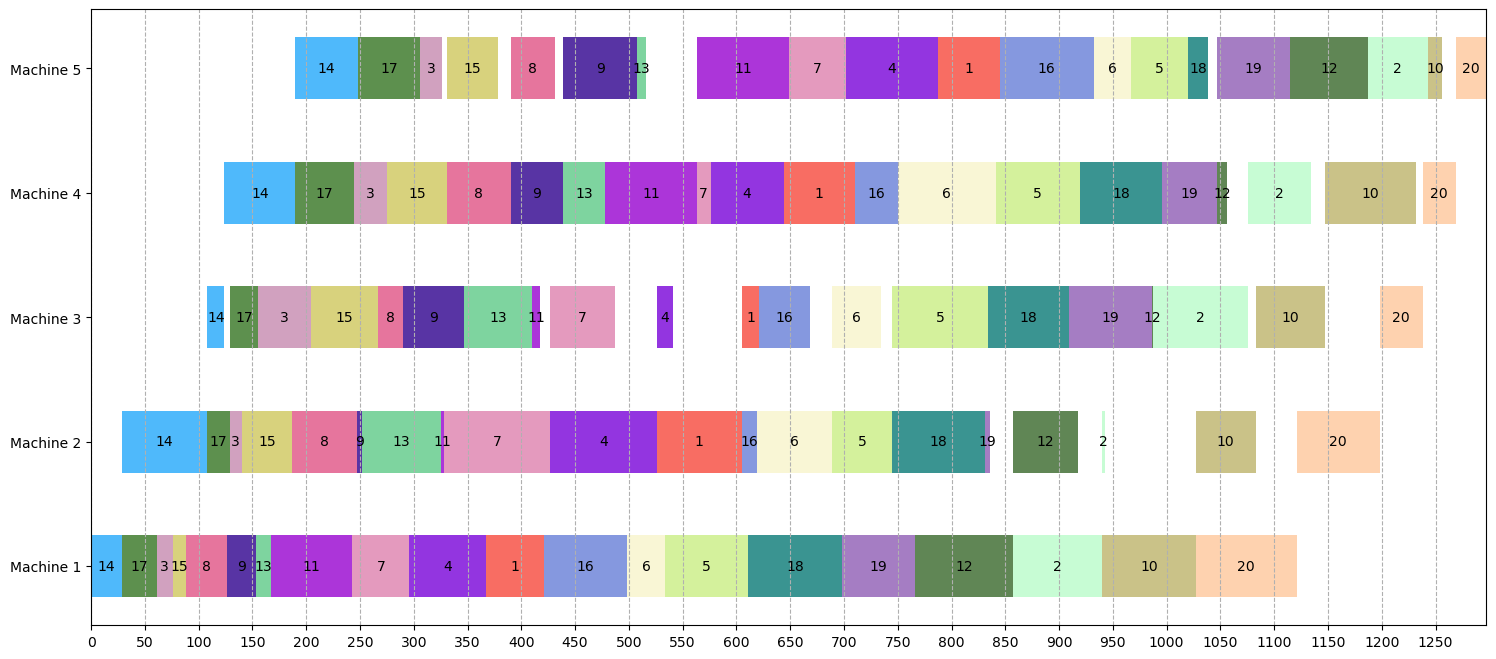

In [27]:
generate_gantt_chart(benchmark, rs_solution)

#### With FBA swapping method

In [28]:
rs_fba_solution, best_global_found = RS_fba(benchmark, permutation, best_global, 5,alpha=optimal_alpha, nb_palier=optimal_Nb_palier, it_max=optimal__it_max)

init_sol:  [12, 10, 11, 1, 6, 18, 3, 19, 14, 0, 5, 4, 16, 7, 17, 2, 8, 9, 13, 15]  makespan =  1583
initial_global_solution:  [5, 9, 8, 13, 16, 3, 6, 11, 14, 10, 19, 7, 18, 15, 4, 12, 1, 17, 0, 2]  global_makespan =  1461


Elapsed time: 135.11004185676575 seconds 



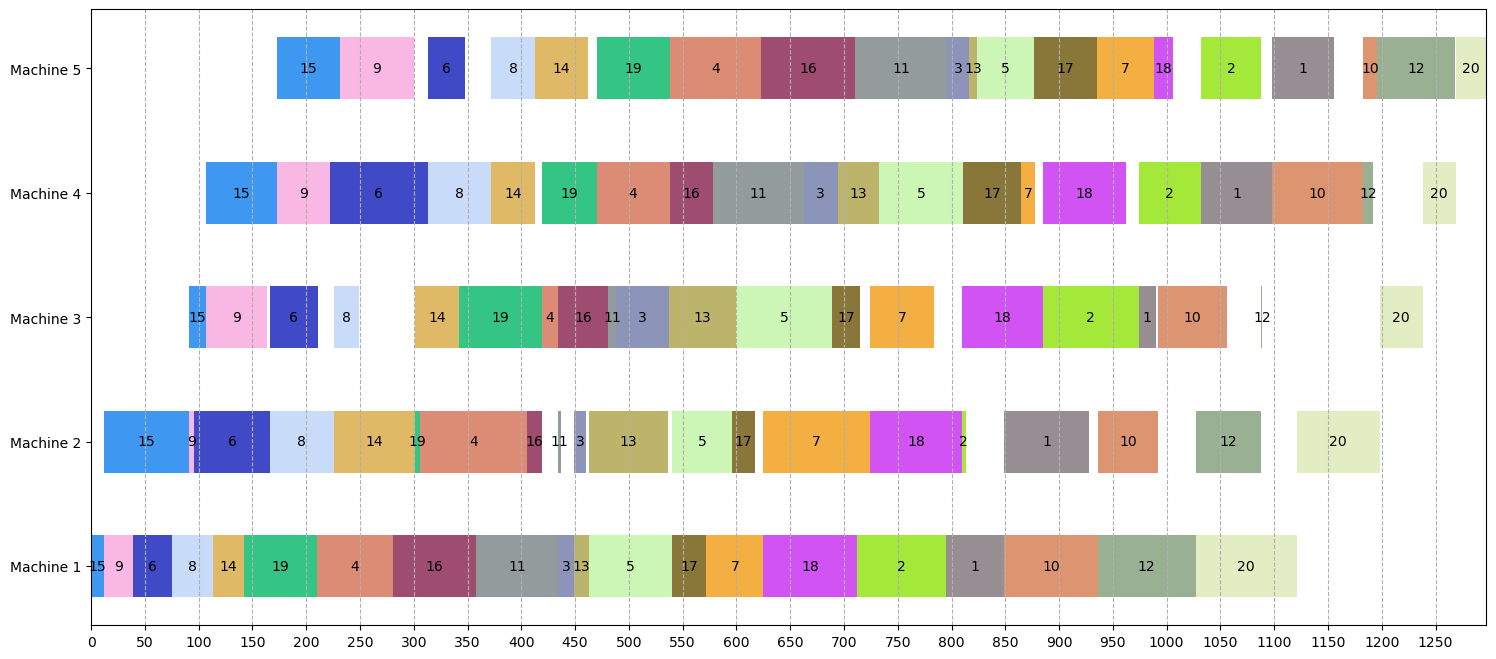

In [29]:
generate_gantt_chart(benchmark, rs_fba_solution)

In [30]:
print('Results of random:')
print(f'First sequence: {permutation} with a makespan of {calculate_makespan(benchmark, permutation)}.')
print('\nResults of RS Random swap:')
print(f'Best solution: {rs_solution} with a makespan of {calculate_makespan(benchmark, rs_solution)}.')
print('\nResults of RS Best swap:')
print(f'Best solution: {rs_solution_best} with a makespan of {calculate_makespan(benchmark, rs_solution_best)}.')
print('\nResults of RS First swap:')
print(f'Best solution: {rs_solution_first} with a makespan of {calculate_makespan(benchmark, rs_solution_first)}.')
print('\nResults of RS_FBA:')
print(f'Best solution: {rs_fba_solution} with a makespan of {calculate_makespan(benchmark, rs_fba_solution)}.')
print(f'Best global solution: {best_global_found} with a makespan of {calculate_makespan(benchmark, best_global_found)}.')

Results of random:
First sequence: [12, 10, 11, 1, 6, 18, 3, 19, 14, 0, 5, 4, 16, 7, 17, 2, 8, 9, 13, 15] with a makespan of 1583.

Results of RS Random swap:
Best solution: [13, 16, 2, 14, 7, 8, 12, 10, 6, 3, 0, 15, 5, 4, 17, 18, 11, 1, 9, 19] with a makespan of 1297.

Results of RS Best swap:
Best solution: [15, 14, 5, 8, 13, 3, 7, 6, 1, 16, 0, 4, 11, 18, 17, 10, 2, 9, 19, 12] with a makespan of 1367.

Results of RS First swap:
Best solution: [13, 8, 5, 12, 3, 18, 15, 10, 14, 7, 17, 4, 16, 6, 1, 0, 9, 19, 11, 2] with a makespan of 1322.

Results of RS_FBA:
Best solution: [14, 8, 5, 7, 13, 18, 3, 15, 10, 2, 12, 4, 16, 6, 17, 1, 0, 9, 11, 19] with a makespan of 1297.
Best global solution: [14, 8, 5, 7, 13, 18, 3, 15, 10, 2, 12, 4, 16, 6, 17, 1, 0, 9, 11, 19] with a makespan of 1297.


### NEH initial solution

#### Without FBA swapping method

In [31]:
initialSolution, makespan = neh_algorithm(benchmark)


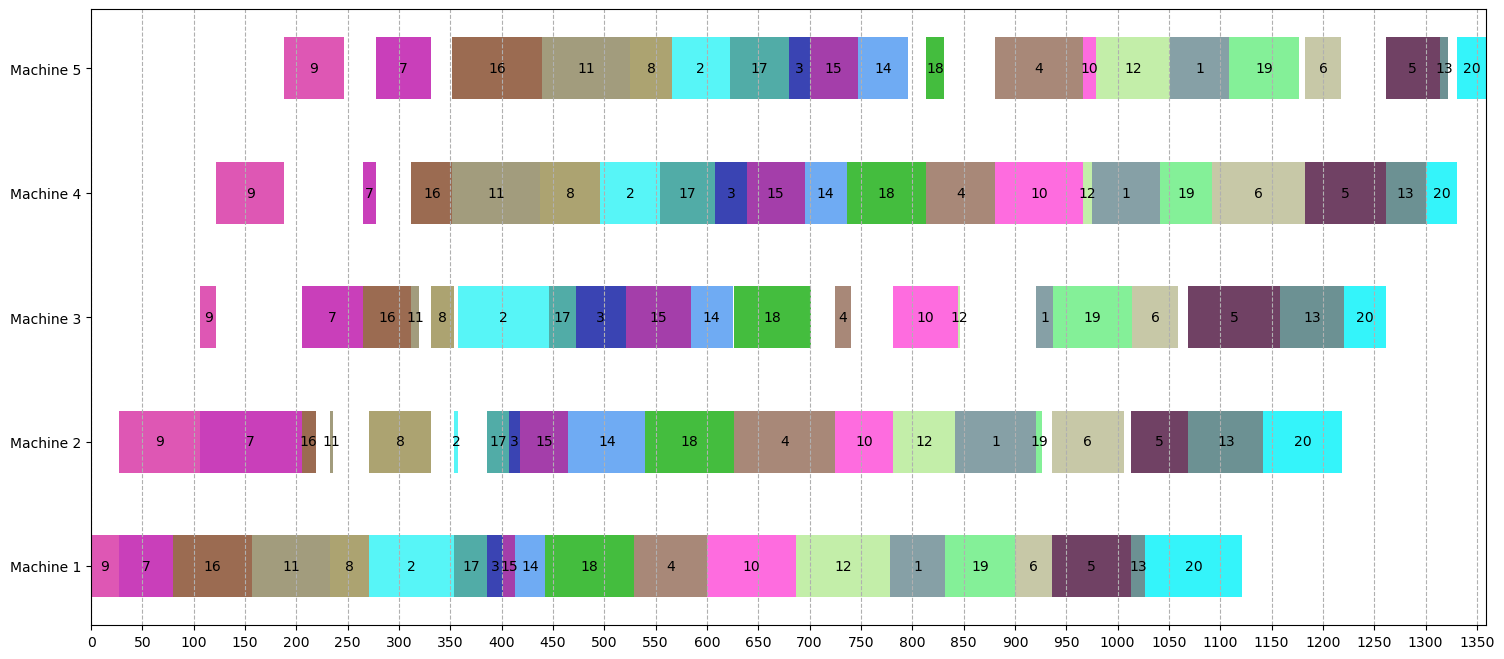

In [32]:
generate_gantt_chart(benchmark, initialSolution)    

In [33]:
print("RS With Random SWAP")
rs_solution = RS(benchmark, initialSolution, 5, method='random_swap',alpha=optimal_alpha, nb_palier=optimal_Nb_palier, it_max=optimal__it_max)
print("RS With Best SWAP")
rs_solution_best = RS(benchmark, initialSolution, 5, method='best_swap',alpha=optimal_alpha, nb_palier=optimal_Nb_palier, it_max=optimal__it_max)
print("RS With First SWAP")
rs_solution_first = RS(benchmark, initialSolution, 5, method='first_admissible_swap',alpha=optimal_alpha, nb_palier=optimal_Nb_palier, it_max=optimal__it_max)

RS With Random SWAP
init_sol:  [8, 6, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 9, 11, 0, 18, 5, 4, 12, 19]  makespan =  1334


Elapsed time: 0.5413637161254883 seconds 

RS With Best SWAP
init_sol:  [8, 6, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 9, 11, 0, 18, 5, 4, 12, 19]  makespan =  1334
Elapsed time: 145.18851971626282 seconds 

RS With First SWAP
init_sol:  [8, 6, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 9, 11, 0, 18, 5, 4, 12, 19]  makespan =  1334
Elapsed time: 154.47863841056824 seconds 



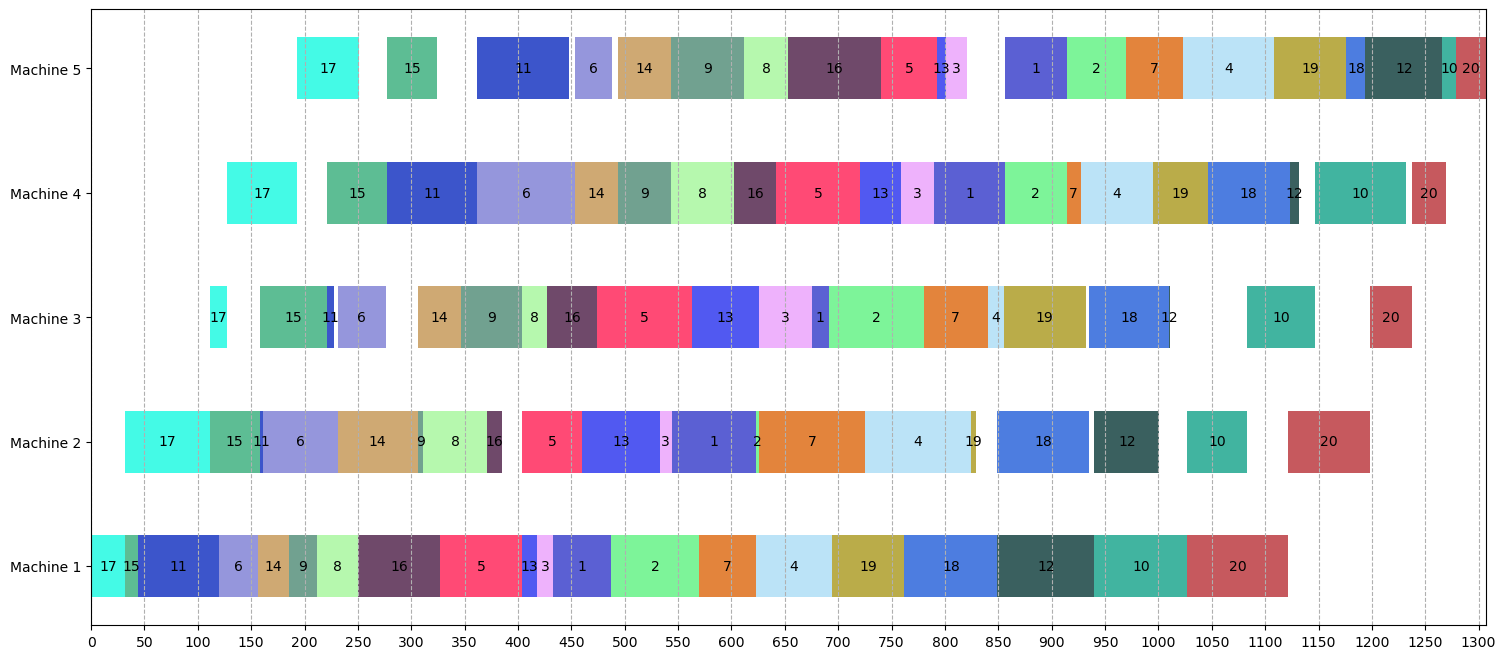

In [34]:
generate_gantt_chart(benchmark, rs_solution)    

#### With FBA swapping method

In [35]:
rs_fba_solution, best_global_found = RS_fba(benchmark, initialSolution, best_global, 5, alpha=optimal_alpha, nb_palier=optimal_Nb_palier, it_max=optimal__it_max)

init_sol:  [8, 6, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 9, 11, 0, 18, 5, 4, 12, 19]  makespan =  1334
initial_global_solution:  [5, 9, 8, 13, 16, 3, 6, 11, 14, 10, 19, 7, 18, 15, 4, 12, 1, 17, 0, 2]  global_makespan =  1461


Elapsed time: 128.2600874900818 seconds 



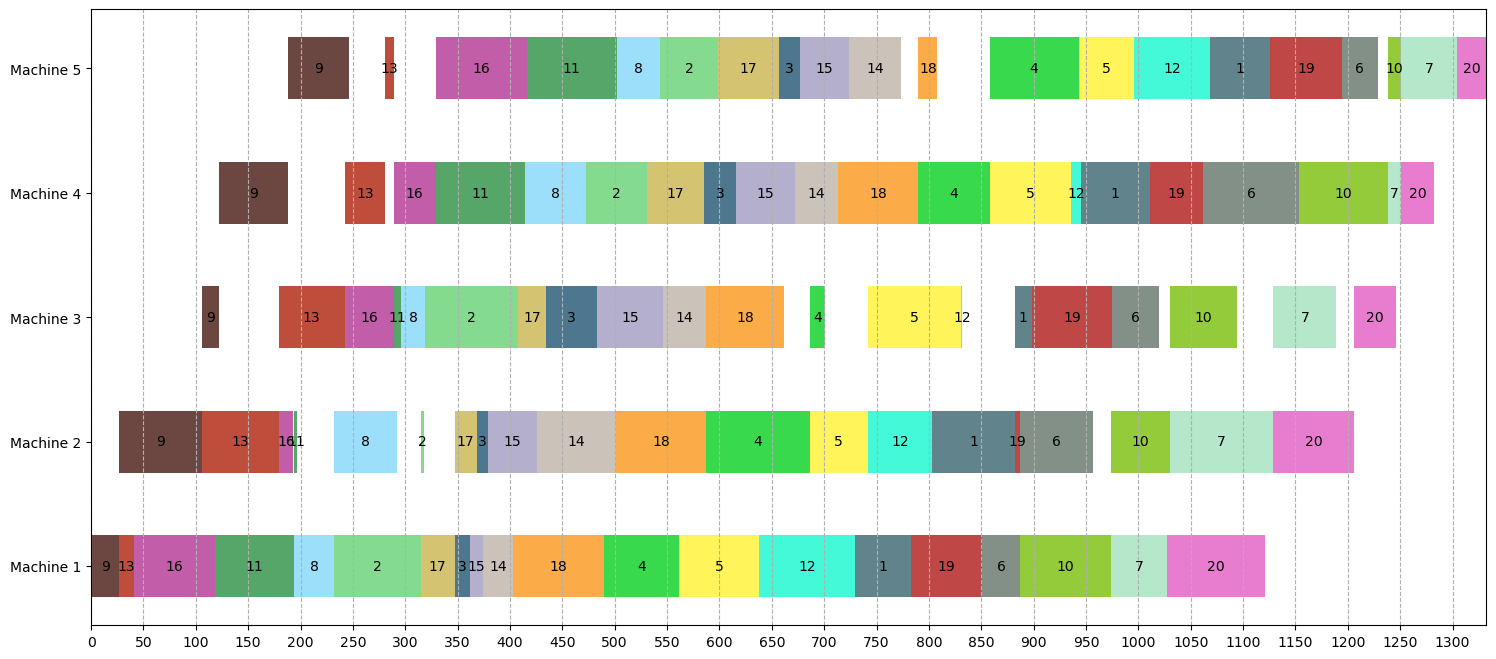

In [36]:
generate_gantt_chart(benchmark, rs_fba_solution)

In [37]:
print('Results of NEH:')
print(f'First sequence: {initialSolution} with a makespan of {makespan}.')
print('\nResults of RS:')
print(f'Best solution: {rs_solution} with a makespan of {calculate_makespan(benchmark, rs_solution)}.')
print('\nResults of RS Best swap:')
print(f'Best solution: {rs_solution_best} with a makespan of {calculate_makespan(benchmark, rs_solution_best)}.')
print('\nResults of RS First swap:')
print(f'Best solution: {rs_solution_first} with a makespan of {calculate_makespan(benchmark, rs_solution_first)}.')
print('\nResults of RS_FBA:')
print(f'Best solution: {rs_fba_solution} with a makespan of {calculate_makespan(benchmark, rs_fba_solution)}.')
print(f'Best global solution: {best_global_found} with a makespan of {calculate_makespan(benchmark, best_global_found)}.')

Results of NEH:
First sequence: [8, 6, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 9, 11, 0, 18, 5, 4, 12, 19] with a makespan of 1334.

Results of RS:
Best solution: [16, 14, 10, 5, 13, 8, 7, 15, 4, 12, 2, 0, 1, 6, 3, 18, 17, 11, 9, 19] with a makespan of 1297.

Results of RS Best swap:
Best solution: [8, 12, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 4, 11, 0, 18, 5, 9, 6, 19] with a makespan of 1305.

Results of RS First swap:
Best solution: [8, 12, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 4, 11, 0, 18, 5, 9, 6, 19] with a makespan of 1305.

Results of RS_FBA:
Best solution: [8, 12, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 4, 11, 0, 18, 5, 9, 6, 19] with a makespan of 1305.
Best global solution: [8, 12, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 4, 11, 0, 18, 5, 9, 6, 19] with a makespan of 1305.


### PRSKE initial solution

#### Without FBA swapping method

In [38]:
initialSolution, makespan  = PRSKE(benchmark)

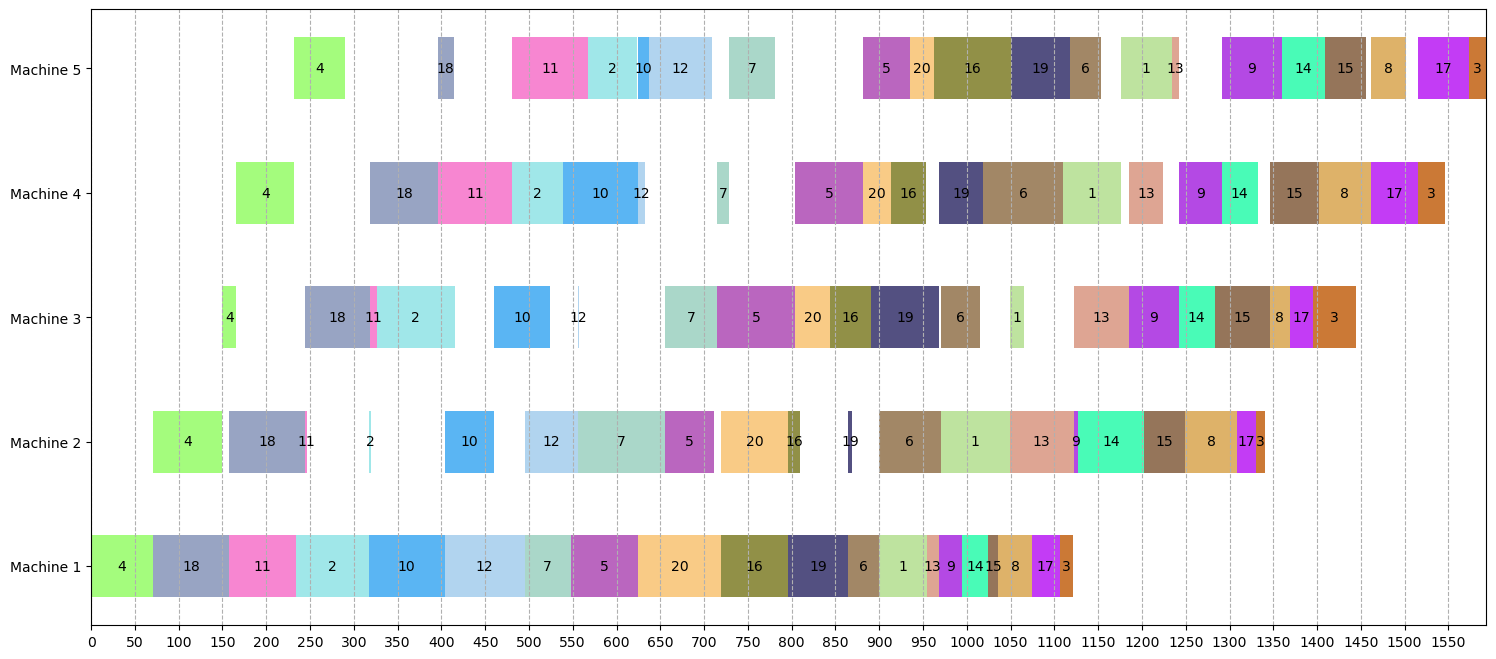

In [39]:
generate_gantt_chart(benchmark, initialSolution)

In [40]:
print("RS With Random SWAP")
rs_solution = RS(benchmark, initialSolution, 5, method='random_swap',alpha=optimal_alpha, nb_palier=optimal_Nb_palier, it_max=optimal__it_max)
print("RS With Best SWAP")
rs_solution_best = RS(benchmark, initialSolution, 5, method='best_swap',alpha=optimal_alpha, nb_palier=optimal_Nb_palier, it_max=optimal__it_max)
print("RS With First SWAP")
rs_solution_first = RS(benchmark, initialSolution, 5, method='first_admissible_swap',alpha=optimal_alpha, nb_palier=optimal_Nb_palier, it_max=optimal__it_max)

RS With Random SWAP
init_sol:  [3, 17, 10, 1, 9, 11, 6, 4, 19, 15, 18, 5, 0, 12, 8, 13, 14, 7, 16, 2]  makespan =  1593


Elapsed time: 0.5134425163269043 seconds 

RS With Best SWAP
init_sol:  [3, 17, 10, 1, 9, 11, 6, 4, 19, 15, 18, 5, 0, 12, 8, 13, 14, 7, 16, 2]  makespan =  1593
Elapsed time: 143.4166340827942 seconds 

RS With First SWAP
init_sol:  [3, 17, 10, 1, 9, 11, 6, 4, 19, 15, 18, 5, 0, 12, 8, 13, 14, 7, 16, 2]  makespan =  1593
Elapsed time: 135.60333442687988 seconds 



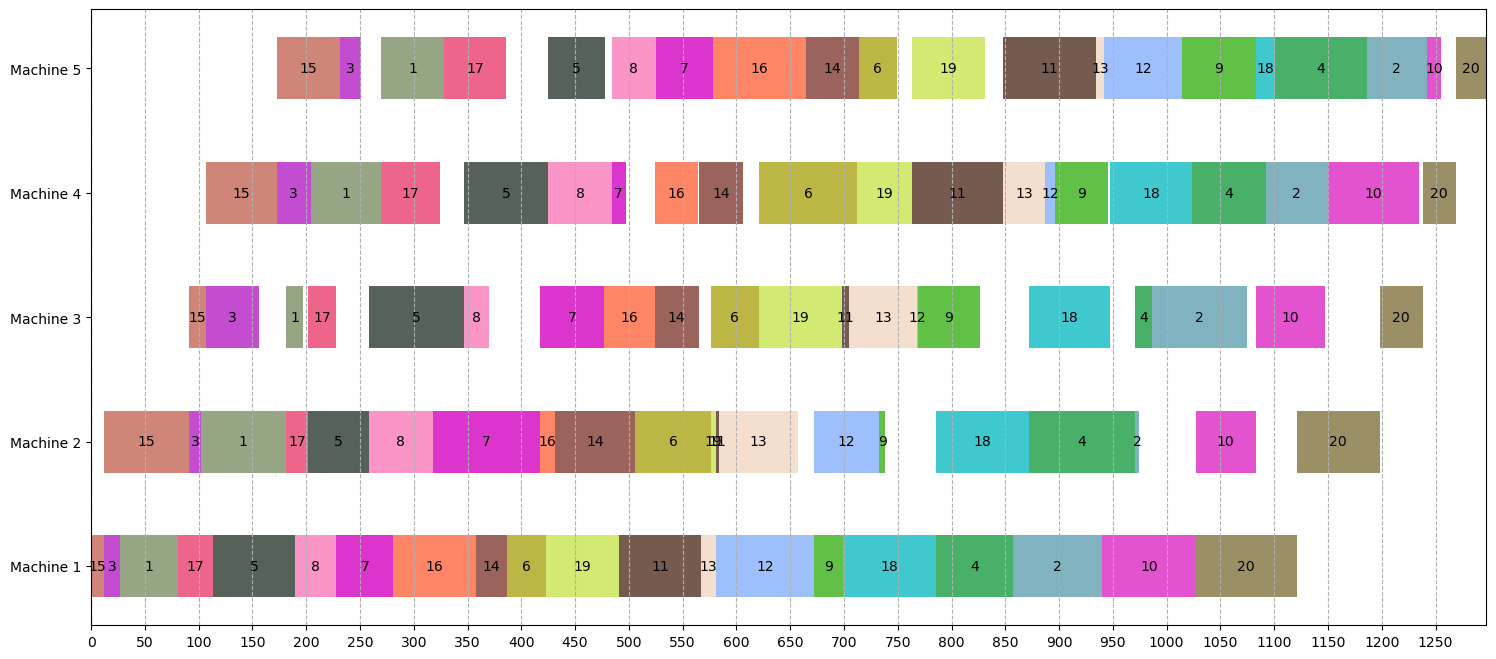

In [41]:
generate_gantt_chart(benchmark, rs_solution)

#### With FBA swapping method

In [42]:
rs_fba_solution, best_global_found = RS_fba(benchmark, initialSolution, best_global, 5, alpha=optimal_alpha, nb_palier=optimal_Nb_palier, it_max=optimal__it_max)

init_sol:  [3, 17, 10, 1, 9, 11, 6, 4, 19, 15, 18, 5, 0, 12, 8, 13, 14, 7, 16, 2]  makespan =  1593
initial_global_solution:  [5, 9, 8, 13, 16, 3, 6, 11, 14, 10, 19, 7, 18, 15, 4, 12, 1, 17, 0, 2]  global_makespan =  1461


Elapsed time: 138.85672760009766 seconds 



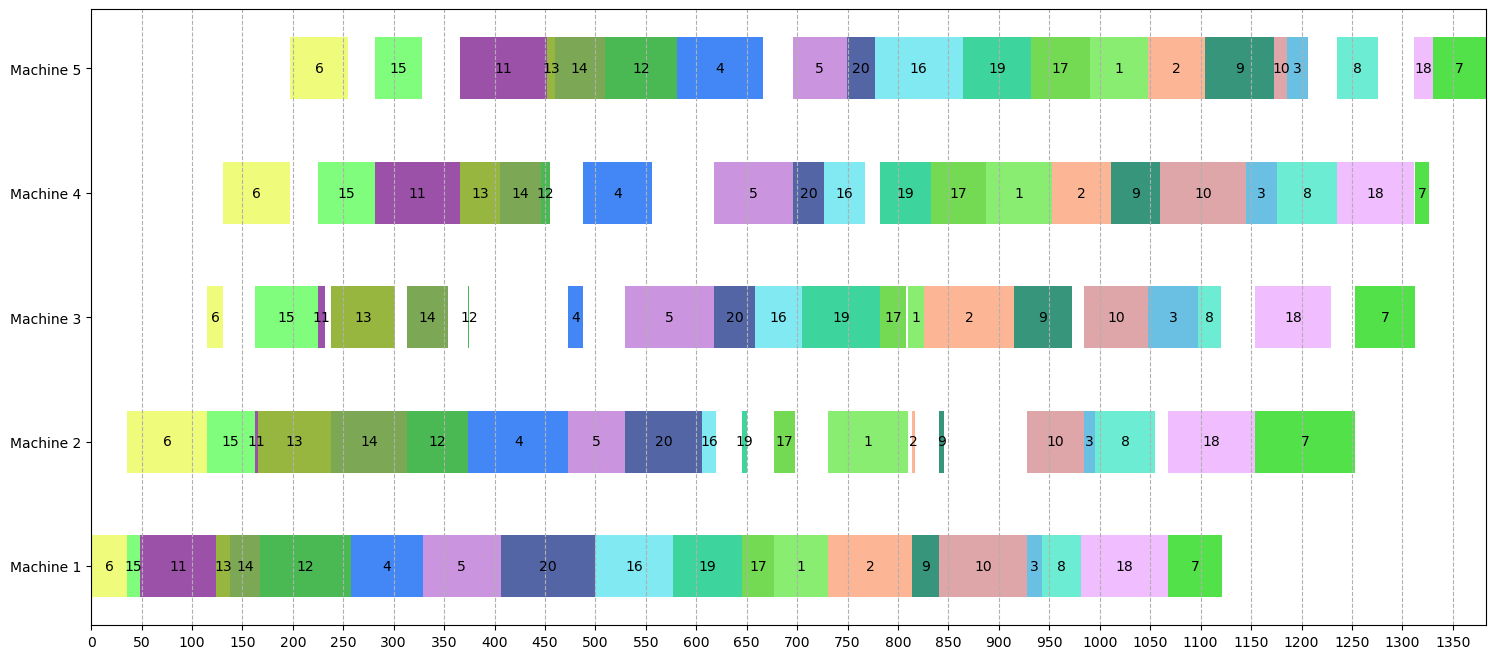

In [43]:
generate_gantt_chart(benchmark, rs_fba_solution)

In [44]:
print('Results of PRSKE:')
print(f'First sequence: {initialSolution} with a makespan of {makespan}.')
print('\nResults of RS Random swap:')
print(f'Best solution: {rs_solution} with a makespan of {calculate_makespan(benchmark, rs_solution)}')
print('\nResults of RS Best swap:')
print(f'Best solution: {rs_solution_best} with a makespan of {calculate_makespan(benchmark, rs_solution_best)}.')
print('\nResults of RS First swap:')
print(f'Best solution: {rs_solution_first} with a makespan of {calculate_makespan(benchmark, rs_solution_first)}.')
print('\nResults of RS_FBA:')
print(f'Best solution: {rs_fba_solution} with a makespan of {calculate_makespan(benchmark, rs_fba_solution)}.')
print(f'Best global solution: {best_global_found} with a makespan of {calculate_makespan(benchmark, best_global_found)}.')

Results of PRSKE:
First sequence: [3, 17, 10, 1, 9, 11, 6, 4, 19, 15, 18, 5, 0, 12, 8, 13, 14, 7, 16, 2] with a makespan of 1593.

Results of RS Random swap:
Best solution: [14, 2, 0, 16, 4, 7, 6, 15, 13, 5, 18, 10, 12, 11, 8, 17, 3, 1, 9, 19] with a makespan of 1297

Results of RS Best swap:
Best solution: [8, 5, 0, 16, 7, 4, 3, 13, 2, 10, 18, 12, 15, 1, 14, 17, 11, 9, 6, 19] with a makespan of 1305.

Results of RS First swap:
Best solution: [14, 5, 7, 8, 17, 6, 10, 4, 2, 15, 0, 18, 12, 3, 16, 1, 13, 9, 19, 11] with a makespan of 1294.

Results of RS_FBA:
Best solution: [5, 14, 10, 12, 13, 11, 3, 4, 19, 15, 18, 16, 0, 1, 8, 9, 2, 7, 17, 6] with a makespan of 1379.
Best global solution: [5, 14, 10, 12, 13, 11, 3, 4, 19, 15, 18, 16, 0, 1, 8, 9, 2, 7, 17, 6] with a makespan of 1379.


##  Taillard, 50 jobs et 10 machines

In [45]:
nb_jobs = 50
nb_machines = 10

In [46]:
benchmarks = read_flow_shop_data(f'./utils/benchmarks/{nb_jobs}_{nb_machines}.txt', nb_machines, nb_jobs)
benchmark = benchmarks[0][2].T
benchmark

array([[46, 61,  3, 51, 37, 79, 83, 22, 27, 24],
       [52, 87,  1, 24, 16, 93, 87, 29, 92, 47],
       [79, 51, 58, 21, 42, 68, 38, 99, 75, 39],
       [45, 25, 85, 57, 47, 75, 38, 25, 94, 66],
       [97, 73, 33, 69, 94, 37, 86, 98, 18, 41],
       [10, 93, 71, 51, 14, 44, 67, 55, 41, 46],
       [44, 28, 58, 50, 94, 34, 23, 80, 37, 24],
       [24, 90, 56, 51, 34, 39, 19, 82, 58, 23],
       [85, 94, 64, 21, 72, 76, 97, 33, 56, 68],
       [75, 59, 43, 19, 36, 62, 78, 68, 20, 50],
       [66, 64, 48, 63, 88, 74, 66, 47,  2, 93],
       [49,  2, 69, 91, 51, 28, 67, 74, 39, 22],
       [95, 16, 96, 11, 41, 78,  7, 26, 91, 64],
       [61, 35, 35,  6, 71, 43, 23, 61, 81, 81],
       [19, 53, 82, 31, 94, 98, 67, 95, 33, 94],
       [47, 40, 53, 63, 99, 83,  8, 55, 14, 97],
       [84, 81, 64, 36, 11, 91, 77, 11, 88, 54],
       [13, 26, 11, 39, 97, 27, 71, 42, 22, 82],
       [11, 85, 61, 57, 44,  6, 85, 72, 36, 11],
       [19,  4, 36, 47, 77, 82, 29, 14, 65, 91],
       [98,  4, 53, 

- Obtenir les meilleurs paramètres 

In [47]:
rnd_data, permutation, Cmax, optimal_alpha, optimal_Nb_palier, optimal__it_max = optimal_params(benchmark,nb_jobs,nb_machines)

[[ 88 117  62  12 111  27  96  72  54  30]
 [ 68 100  86  50 101  56  79  41  38  56]
 [ 87  43  38  41 108  28  24  74  95   9]
 [ 98  33  61  76  80  88   7 109  21 104]
 [ 96  58  36 119  42   8  35  84 118  68]
 [ 41  90  82  43  17  53  70 107  96   7]
 [ 20   5  50  57  68 109  26  96 110   8]
 [ 64  73  99  75  83  66 106  32  28  16]
 [ 95 100  91  54  46  81  70 112  94  37]
 [ 63  46  76  91  37  76 116  48  69 101]
 [ 31  95   7  93  63  80  33  51  58  61]
 [ 58  75  86  87  59  17  64  87  94 119]
 [ 42  71  26  65  88  60 106  29  42  26]
 [ 69  61  19   9  12  40  21  88 103  68]
 [ 93  89  59  18  66   7  78  49  98  64]
 [ 84  55  21  51  25   8  56  68 108   9]
 [102  97  36  89  96  76  51  81  26 116]
 [ 11 102  56  54  17  55  72  12  54 113]
 [ 39  79  76  70  57 105  30  80  20  40]
 [ 80  46  23  37  48  95  62  83  15  58]
 [ 84  11  27  62  54  92  55 106  36  22]
 [ 75  54 106  36  65   8  69  41  11   7]
 [ 61  58 106 104  59 116  72  21  70  45]
 [ 37  98  

Elapsed time: 4.861250638961792 seconds 

init_sol:  [45, 43, 25, 23, 6, 28, 15, 24, 8, 14, 27, 37, 44, 47, 48, 21, 17, 9, 16, 41, 13, 33, 20, 26, 22, 40, 18, 7, 39, 12, 35, 2, 38, 5, 11, 30, 36, 31, 29, 4, 49, 19, 32, 1, 34, 46, 3, 42, 0, 10]  makespan =  3808
Elapsed time: 2.1908364295959473 seconds 

init_sol:  [45, 43, 25, 23, 6, 28, 15, 24, 8, 14, 27, 37, 44, 47, 48, 21, 17, 9, 16, 41, 13, 33, 20, 26, 22, 40, 18, 7, 39, 12, 35, 2, 38, 5, 11, 30, 36, 31, 29, 4, 49, 19, 32, 1, 34, 46, 3, 42, 0, 10]  makespan =  3808
Elapsed time: 0.9457333087921143 seconds 

init_sol:  [45, 43, 25, 23, 6, 28, 15, 24, 8, 14, 27, 37, 44, 47, 48, 21, 17, 9, 16, 41, 13, 33, 20, 26, 22, 40, 18, 7, 39, 12, 35, 2, 38, 5, 11, 30, 36, 31, 29, 4, 49, 19, 32, 1, 34, 46, 3, 42, 0, 10]  makespan =  3808
Elapsed time: 2.587998628616333 seconds 

init_sol:  [45, 43, 25, 23, 6, 28, 15, 24, 8, 14, 27, 37, 44, 47, 48, 21, 17, 9, 16, 41, 13, 33, 20, 26, 22, 40, 18, 7, 39, 12, 35, 2, 38, 5, 11, 30, 36, 31, 29, 4, 49, 1

In [48]:
best_global = np.random.permutation(nb_jobs).tolist()
while calculate_makespan(rnd_data, best_global) > Cmax:
    best_global = np.random.permutation(nb_jobs).tolist()

benchmark

array([[46, 61,  3, 51, 37, 79, 83, 22, 27, 24],
       [52, 87,  1, 24, 16, 93, 87, 29, 92, 47],
       [79, 51, 58, 21, 42, 68, 38, 99, 75, 39],
       [45, 25, 85, 57, 47, 75, 38, 25, 94, 66],
       [97, 73, 33, 69, 94, 37, 86, 98, 18, 41],
       [10, 93, 71, 51, 14, 44, 67, 55, 41, 46],
       [44, 28, 58, 50, 94, 34, 23, 80, 37, 24],
       [24, 90, 56, 51, 34, 39, 19, 82, 58, 23],
       [85, 94, 64, 21, 72, 76, 97, 33, 56, 68],
       [75, 59, 43, 19, 36, 62, 78, 68, 20, 50],
       [66, 64, 48, 63, 88, 74, 66, 47,  2, 93],
       [49,  2, 69, 91, 51, 28, 67, 74, 39, 22],
       [95, 16, 96, 11, 41, 78,  7, 26, 91, 64],
       [61, 35, 35,  6, 71, 43, 23, 61, 81, 81],
       [19, 53, 82, 31, 94, 98, 67, 95, 33, 94],
       [47, 40, 53, 63, 99, 83,  8, 55, 14, 97],
       [84, 81, 64, 36, 11, 91, 77, 11, 88, 54],
       [13, 26, 11, 39, 97, 27, 71, 42, 22, 82],
       [11, 85, 61, 57, 44,  6, 85, 72, 36, 11],
       [19,  4, 36, 47, 77, 82, 29, 14, 65, 91],
       [98,  4, 53, 

### Random initial solution

#### Without FBA swapping method

In [49]:
print("RS With Random SWAP")
rs_solution = RS(benchmark, permutation, 5, method='random_swap',alpha=optimal_alpha, nb_palier=optimal_Nb_palier, it_max=optimal__it_max)

RS With Random SWAP
init_sol:  [45, 43, 25, 23, 6, 28, 15, 24, 8, 14, 27, 37, 44, 47, 48, 21, 17, 9, 16, 41, 13, 33, 20, 26, 22, 40, 18, 7, 39, 12, 35, 2, 38, 5, 11, 30, 36, 31, 29, 4, 49, 19, 32, 1, 34, 46, 3, 42, 0, 10]  makespan =  3808
Elapsed time: 2.8053832054138184 seconds 



#### Diagramme de Gantt du RS avec Random Swap

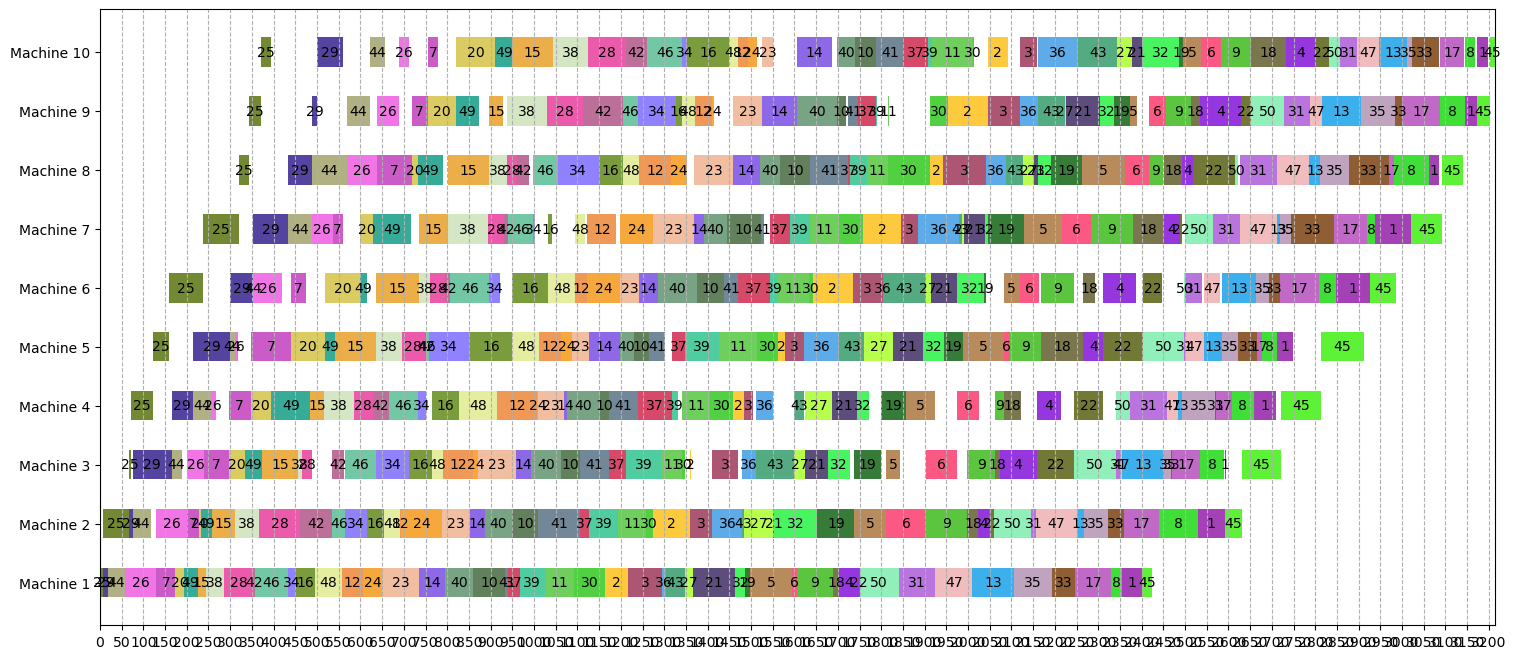

In [50]:
generate_gantt_chart(benchmark, rs_solution)

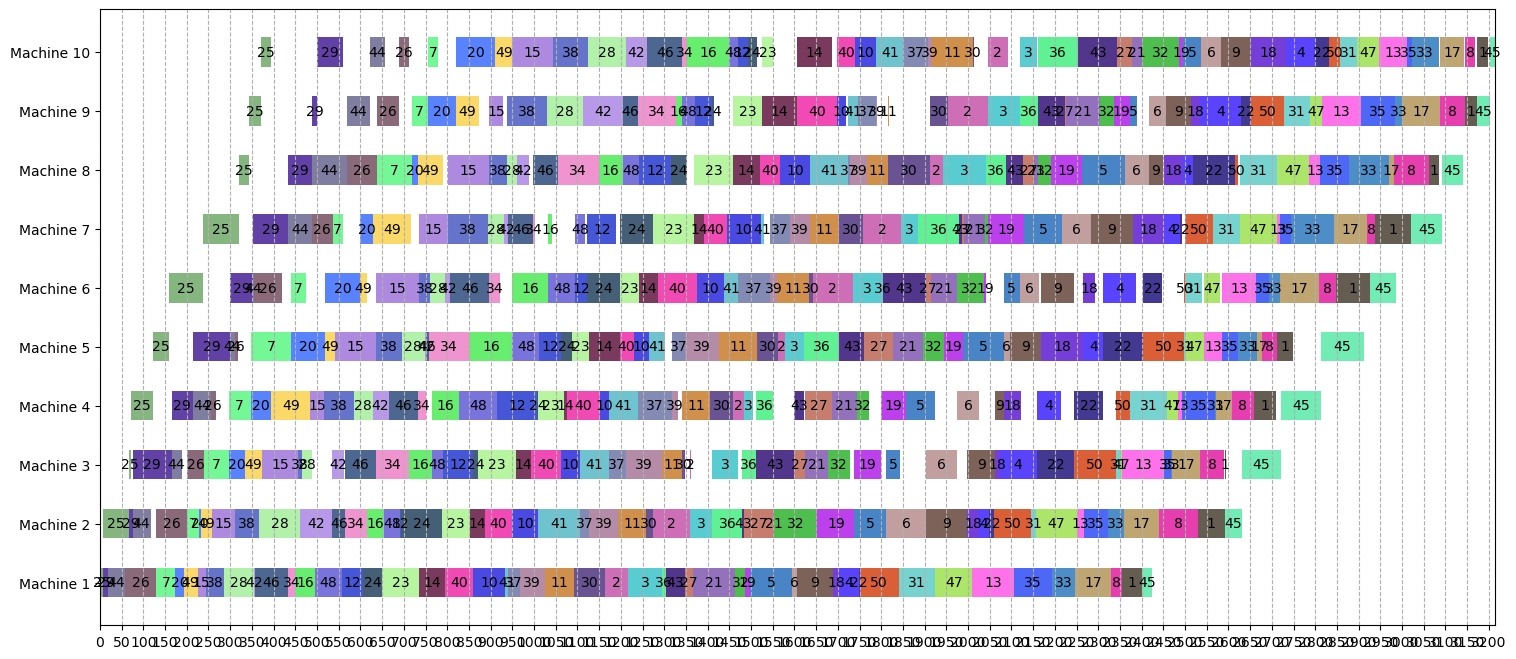

In [51]:
generate_gantt_chart(benchmark, rs_solution)

In [52]:
print('Results of random:')
print(f'First sequence: {permutation} with a makespan of {calculate_makespan(benchmark, permutation)}.')
print('\nResults of RS:')
print(f'Best solution: {rs_solution} with a makespan of {calculate_makespan(benchmark, rs_solution)}.')
# print('\nResults of RS_FBA:')
# print(f'Best solution: {rs_fba_solution} with a makespan of {calculate_makespan(benchmark, rs_fba_solution)}.')
# print(f'Best global solution: {best_global_found} with a makespan of {calculate_makespan(benchmark, best_global_found)}.')

Results of random:
First sequence: [45, 43, 25, 23, 6, 28, 15, 24, 8, 14, 27, 37, 44, 47, 48, 21, 17, 9, 16, 41, 13, 33, 20, 26, 22, 40, 18, 7, 39, 12, 35, 2, 38, 5, 11, 30, 36, 31, 29, 4, 49, 19, 32, 1, 34, 46, 3, 42, 0, 10] with a makespan of 3808.

Results of RS:
Best solution: [24, 28, 43, 25, 6, 19, 48, 14, 37, 27, 41, 45, 33, 15, 47, 11, 23, 22, 13, 39, 9, 40, 36, 38, 10, 29, 1, 2, 35, 42, 26, 20, 31, 18, 4, 5, 8, 17, 3, 21, 49, 30, 46, 12, 34, 32, 16, 7, 0, 44] with a makespan of 3220.


### NEH initial solution

#### Without FBA swapping method

In [53]:
initialSolution, makespan = neh_algorithm(benchmark)

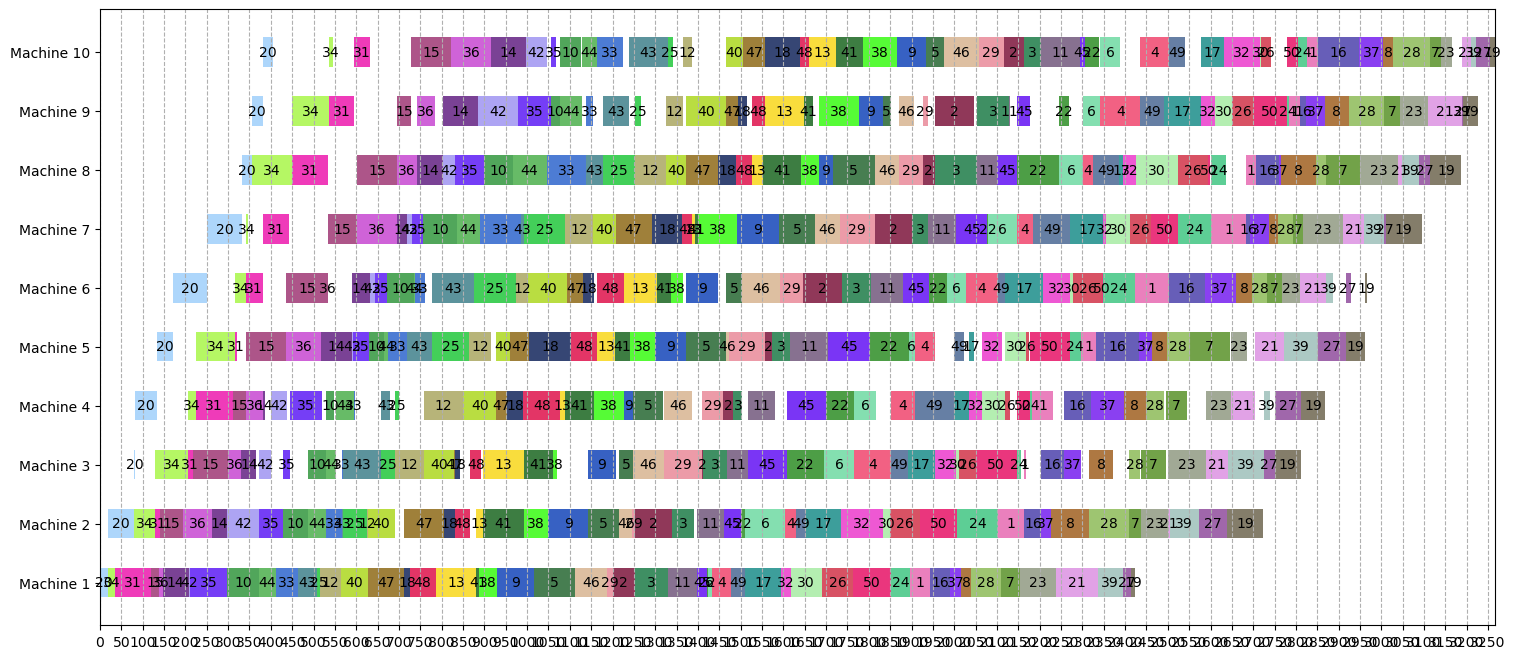

In [54]:
generate_gantt_chart(benchmark, initialSolution)    

In [55]:
print("RS With Random SWAP")
rs_solution = RS(benchmark, initialSolution, 5, method='random_swap',alpha=optimal_alpha, nb_palier=optimal_Nb_palier, it_max=optimal__it_max)

RS With Random SWAP
init_sol:  [19, 33, 30, 14, 35, 13, 41, 34, 9, 43, 32, 42, 24, 11, 39, 46, 17, 47, 12, 40, 37, 8, 4, 45, 28, 1, 2, 10, 44, 21, 5, 3, 48, 16, 31, 29, 25, 49, 23, 0, 15, 36, 7, 27, 6, 22, 20, 38, 26, 18]  makespan =  3229


Elapsed time: 2.3107614517211914 seconds 



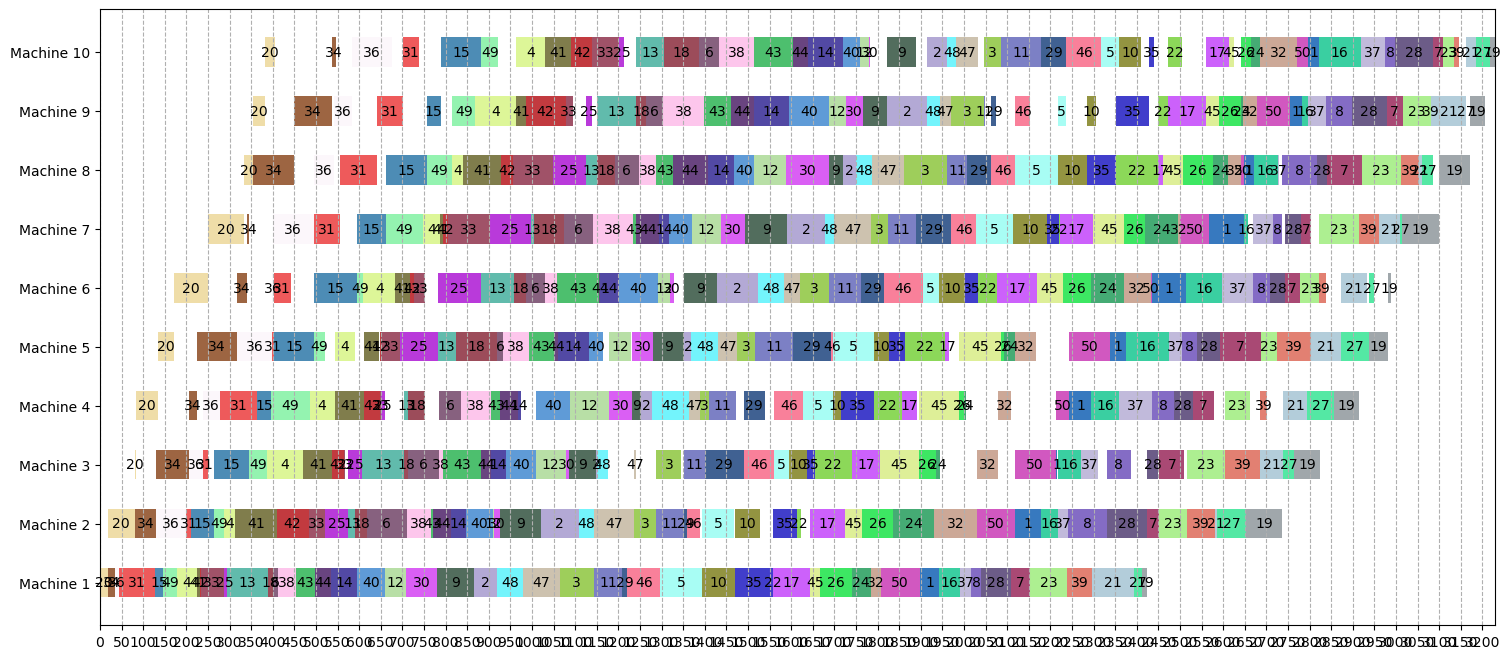

In [56]:
generate_gantt_chart(benchmark, rs_solution)    

In [57]:
print('Results of NEH:')
print(f'First sequence: {initialSolution} with a makespan of {makespan}.')
print('\nResults of RS:')
print(f'Best solution: {rs_solution} with a makespan of {calculate_makespan(benchmark, rs_solution)}.')
# print('\nResults of RS_FBA:')
# print(f'Best solution: {rs_fba_solution} with a makespan of {calculate_makespan(benchmark, rs_fba_solution)}.')
# print(f'Best global solution: {best_global_found} with a makespan of {calculate_makespan(benchmark, best_global_found)}.')

Results of NEH:
First sequence: [19, 33, 30, 14, 35, 13, 41, 34, 9, 43, 32, 42, 24, 11, 39, 46, 17, 47, 12, 40, 37, 8, 4, 45, 28, 1, 2, 10, 44, 21, 5, 3, 48, 16, 31, 29, 25, 49, 23, 0, 15, 36, 7, 27, 6, 22, 20, 38, 26, 18] with a makespan of 3229.

Results of RS:
Best solution: [19, 33, 35, 30, 14, 48, 3, 40, 41, 32, 24, 12, 17, 5, 37, 42, 43, 13, 39, 11, 29, 8, 1, 47, 46, 2, 10, 28, 45, 4, 9, 34, 21, 16, 44, 25, 23, 31, 49, 0, 15, 36, 7, 27, 6, 22, 38, 20, 26, 18] with a makespan of 3192.


### PRSKE initial solution

#### Without FBA swapping method

In [58]:
initialSolution, makespan  = PRSKE(benchmark)

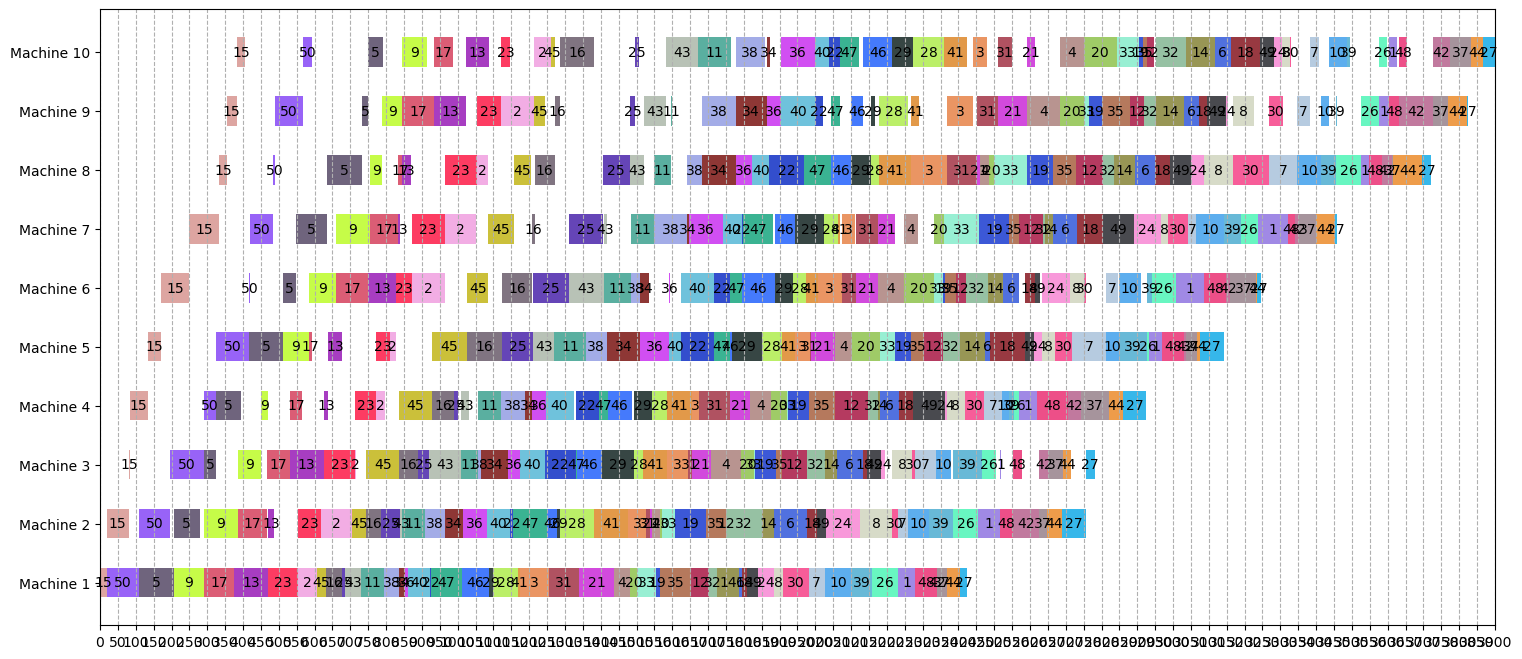

In [59]:
generate_gantt_chart(benchmark, initialSolution)

In [60]:
print("RS With Random SWAP")
rs_solution = RS(benchmark, initialSolution, 5, method='random_swap',alpha=optimal_alpha, nb_palier=optimal_Nb_palier, it_max=optimal__it_max)

RS With Random SWAP
init_sol:  [14, 49, 4, 8, 16, 12, 22, 1, 44, 15, 24, 42, 10, 37, 33, 35, 39, 21, 46, 45, 28, 27, 40, 2, 30, 20, 3, 19, 32, 18, 34, 11, 31, 13, 5, 17, 48, 23, 7, 29, 6, 9, 38, 25, 0, 47, 41, 36, 43, 26]  makespan =  3900


Elapsed time: 3.1497373580932617 seconds 



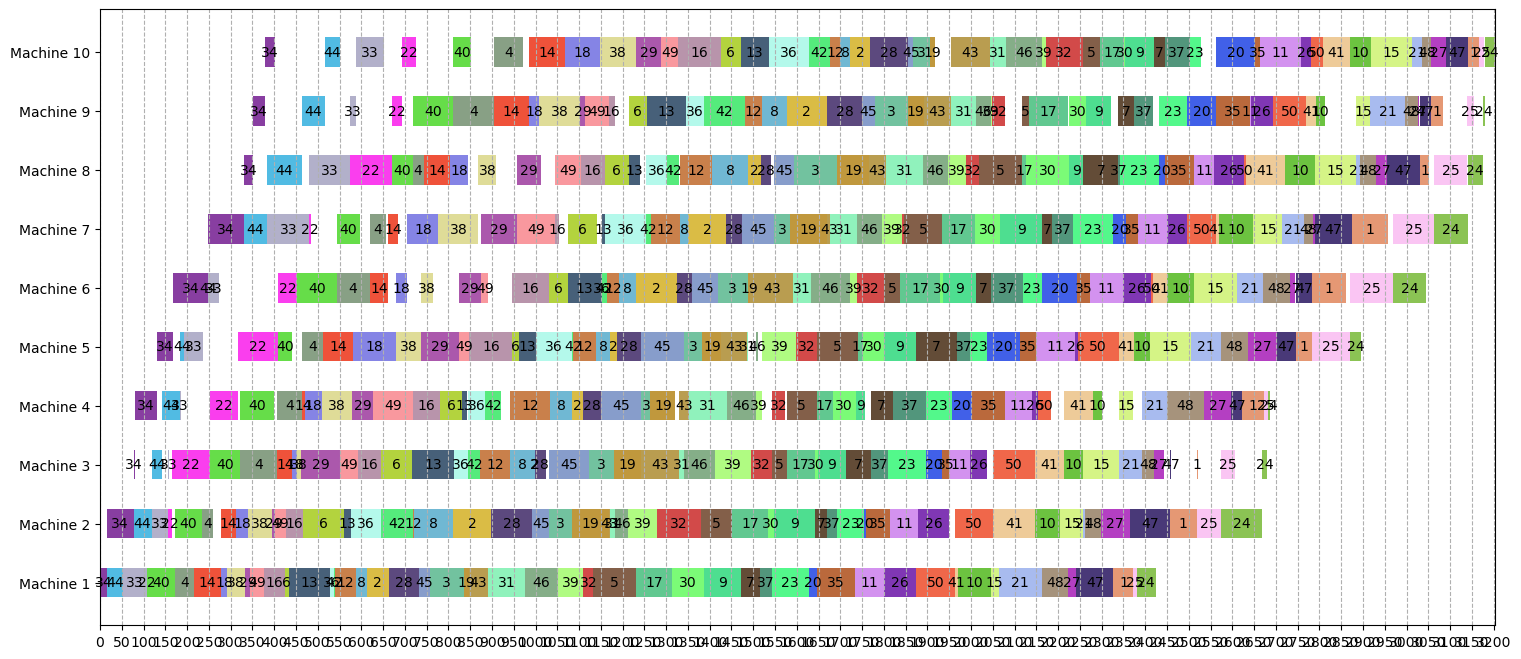

In [61]:
generate_gantt_chart(benchmark, rs_solution)

In [62]:
print('Results of PRSKE:')
print(f'First sequence: {initialSolution} with a makespan of {makespan}.')
print('\nResults of RS:')
print(f'Best solution: {rs_solution} with a makespan of {calculate_makespan(benchmark, rs_solution)}')
# print('\nResults of RS_FBA:')
# print(f'Best solution: {rs_fba_solution} with a makespan of {calculate_makespan(benchmark, rs_fba_solution)}.')
# print(f'Best global solution: {best_global_found} with a makespan of {calculate_makespan(benchmark, best_global_found)}.')

Results of PRSKE:
First sequence: [14, 49, 4, 8, 16, 12, 22, 1, 44, 15, 24, 42, 10, 37, 33, 35, 39, 21, 46, 45, 28, 27, 40, 2, 30, 20, 3, 19, 32, 18, 34, 11, 31, 13, 5, 17, 48, 23, 7, 29, 6, 9, 38, 25, 0, 47, 41, 36, 43, 26] with a makespan of 3900.

Results of RS:
Best solution: [33, 43, 32, 21, 39, 3, 13, 17, 37, 28, 48, 15, 5, 12, 35, 41, 11, 7, 1, 27, 44, 2, 18, 42, 30, 45, 38, 31, 4, 16, 29, 8, 6, 36, 22, 19, 34, 10, 25, 49, 40, 9, 14, 20, 47, 26, 46, 0, 24, 23] with a makespan of 3203


## Taillard, 100 jobs et 10 machines

In [63]:
nb_jobs = 100
nb_machines = 10

In [64]:
benchmarks = read_flow_shop_data(f'./utils/benchmarks/{nb_jobs}_{nb_machines}.txt', nb_machines, nb_jobs)
benchmark = benchmarks[0][2].T
benchmark

array([[52, 82, 63, 79, 80, 53, 71, 95, 92, 61],
       [95, 21, 55, 21, 13, 19, 90, 53, 62, 86],
       [42, 79, 59, 93, 64, 99, 59, 54, 11, 16],
       [75, 95, 35, 32, 77, 62, 82, 22, 83, 42],
       [44, 46, 21,  8, 17, 88, 22, 84, 87, 14],
       [57, 23, 59, 45, 78, 93, 88, 54, 66, 92],
       [89, 40, 78, 37, 82, 34, 35,  2, 98, 67],
       [53, 95, 25, 78,  4, 72, 49, 80, 42, 77],
       [84, 87, 30, 26, 72, 42, 78, 84, 23, 46],
       [62, 37, 38, 98, 93, 65, 69, 66, 45, 41],
       [91, 24, 78, 17, 68, 39, 76, 25, 52, 78],
       [14, 24, 79, 25, 25, 79,  2, 16,  6,  3],
       [95, 65, 58, 21, 67,  9, 14, 79,  3, 72],
       [89, 62, 44, 28, 80, 26,  3, 90, 64, 95],
       [ 4, 19, 38, 68, 43, 72, 22, 51, 55, 53],
       [95, 67, 76, 24, 93, 29, 26, 29, 97, 59],
       [ 2, 66, 70, 62, 21, 36, 44, 29, 83, 34],
       [97,  6, 72, 89, 33, 48,  1, 90, 42, 66],
       [68, 65, 85, 60, 14, 57,  4, 83, 81, 42],
       [20, 59,  8, 64, 30, 95, 16, 83, 92, 63],
       [33,  2, 10, 

- Obtenir les meilleurs paramètres 

In [65]:
rnd_data, permutation, Cmax, optimal_alpha, optimal_Nb_palier, optimal__it_max = optimal_params(benchmark,nb_jobs,nb_machines)
# rnd_data, initial_solution, Cmax = generate_random_solution(nb_jobs,nb_machines)

[[ 96  25  81  62  26  94  50  70  40  21]
 [ 15  47  51  74   7  72  75  11  61  46]
 [ 67 113  86  55  74  18  64  99  74  91]
 [ 13  81   5 114  62  52  31  20 115  52]
 [ 51  71  85  82  95 117  21  45  22  96]
 [104  27  18  86  53  10 102   8  10  15]
 [ 76  93 104 107  83 103  81  84  65  27]
 [ 87  18  37  45  67  47  82   9  12  69]
 [118  14  90  98 118  98  33  72 116  44]
 [ 72  52  83  84  73  28  28  15  95 101]
 [ 97  92 106  11  12 119   9  64   5  50]
 [ 60  95  28   9 107  17  59   7  76  79]
 [ 92  60  44 115  38  32  66 110  67  70]
 [ 16  18  50  24  30  12  37 114  44  39]
 [ 82  60  19  45  90  81   5  48  81  76]
 [ 64 109  64  51  75  96  43  27  62 101]
 [ 13  90  92  99 101 102 119  52   8   7]
 [119  71 108  94 108 101 105  36 114  79]
 [ 12 101  22  42  59  47   5  71  89  24]
 [ 76 103   6  87   9  92  71  27  97  83]
 [ 71   8  49  56  52  27 110  19  70  18]
 [ 50 119  31  95  86  16  34  80 109  73]
 [117  64  56  59  35  25  59 119  83  10]
 [ 14  11  

Elapsed time: 8.980596780776978 seconds 

init_sol:  [1, 65, 42, 38, 84, 68, 74, 28, 96, 73, 83, 61, 89, 2, 9, 59, 87, 18, 71, 40, 67, 98, 70, 46, 64, 36, 75, 95, 92, 29, 77, 6, 19, 41, 62, 13, 79, 82, 12, 58, 37, 10, 7, 32, 8, 66, 91, 21, 78, 31, 4, 60, 27, 88, 23, 94, 81, 72, 35, 0, 45, 15, 63, 76, 33, 25, 90, 80, 55, 17, 14, 34, 49, 26, 51, 30, 99, 56, 53, 57, 85, 93, 43, 52, 54, 20, 39, 22, 24, 50, 3, 86, 5, 44, 69, 48, 47, 16, 97, 11]  makespan =  6808
Elapsed time: 4.640884876251221 seconds 

init_sol:  [1, 65, 42, 38, 84, 68, 74, 28, 96, 73, 83, 61, 89, 2, 9, 59, 87, 18, 71, 40, 67, 98, 70, 46, 64, 36, 75, 95, 92, 29, 77, 6, 19, 41, 62, 13, 79, 82, 12, 58, 37, 10, 7, 32, 8, 66, 91, 21, 78, 31, 4, 60, 27, 88, 23, 94, 81, 72, 35, 0, 45, 15, 63, 76, 33, 25, 90, 80, 55, 17, 14, 34, 49, 26, 51, 30, 99, 56, 53, 57, 85, 93, 43, 52, 54, 20, 39, 22, 24, 50, 3, 86, 5, 44, 69, 48, 47, 16, 97, 11]  makespan =  6808
Elapsed time: 1.8410086631774902 seconds 

init_sol:  [1, 65, 42, 38, 84, 68

In [66]:
best_global = np.random.permutation(nb_jobs).tolist()
while calculate_makespan(rnd_data, best_global) > Cmax:
    best_global = np.random.permutation(nb_jobs).tolist()

benchmark

array([[52, 82, 63, 79, 80, 53, 71, 95, 92, 61],
       [95, 21, 55, 21, 13, 19, 90, 53, 62, 86],
       [42, 79, 59, 93, 64, 99, 59, 54, 11, 16],
       [75, 95, 35, 32, 77, 62, 82, 22, 83, 42],
       [44, 46, 21,  8, 17, 88, 22, 84, 87, 14],
       [57, 23, 59, 45, 78, 93, 88, 54, 66, 92],
       [89, 40, 78, 37, 82, 34, 35,  2, 98, 67],
       [53, 95, 25, 78,  4, 72, 49, 80, 42, 77],
       [84, 87, 30, 26, 72, 42, 78, 84, 23, 46],
       [62, 37, 38, 98, 93, 65, 69, 66, 45, 41],
       [91, 24, 78, 17, 68, 39, 76, 25, 52, 78],
       [14, 24, 79, 25, 25, 79,  2, 16,  6,  3],
       [95, 65, 58, 21, 67,  9, 14, 79,  3, 72],
       [89, 62, 44, 28, 80, 26,  3, 90, 64, 95],
       [ 4, 19, 38, 68, 43, 72, 22, 51, 55, 53],
       [95, 67, 76, 24, 93, 29, 26, 29, 97, 59],
       [ 2, 66, 70, 62, 21, 36, 44, 29, 83, 34],
       [97,  6, 72, 89, 33, 48,  1, 90, 42, 66],
       [68, 65, 85, 60, 14, 57,  4, 83, 81, 42],
       [20, 59,  8, 64, 30, 95, 16, 83, 92, 63],
       [33,  2, 10, 

### Random initial solution

#### Without FBA swapping method

In [67]:
print("RS With Random SWAP")
rs_solution = RS(benchmark, permutation, 5, method='random_swap',alpha=optimal_alpha, nb_palier=optimal_Nb_palier, it_max=optimal__it_max)

RS With Random SWAP
init_sol:  [1, 65, 42, 38, 84, 68, 74, 28, 96, 73, 83, 61, 89, 2, 9, 59, 87, 18, 71, 40, 67, 98, 70, 46, 64, 36, 75, 95, 92, 29, 77, 6, 19, 41, 62, 13, 79, 82, 12, 58, 37, 10, 7, 32, 8, 66, 91, 21, 78, 31, 4, 60, 27, 88, 23, 94, 81, 72, 35, 0, 45, 15, 63, 76, 33, 25, 90, 80, 55, 17, 14, 34, 49, 26, 51, 30, 99, 56, 53, 57, 85, 93, 43, 52, 54, 20, 39, 22, 24, 50, 3, 86, 5, 44, 69, 48, 47, 16, 97, 11]  makespan =  6808


Elapsed time: 7.314108848571777 seconds 



In [68]:
print('Results of random:')
print(f'First sequence: {permutation} with a makespan of {calculate_makespan(benchmark, permutation)}.')
print('\nResults of RS with Random swap:')
print(f'Best solution: {rs_solution} with a makespan of {calculate_makespan(benchmark, rs_solution)}.')
# print('\nResults of RS_FBA:')
# print(f'Best solution: {rs_fba_solution} with a makespan of {calculate_makespan(benchmark, rs_fba_solution)}.')
# print(f'Best global solution: {best_global_found} with a makespan of {calculate_makespan(benchmark, best_global_found)}.')

Results of random:
First sequence: [1, 65, 42, 38, 84, 68, 74, 28, 96, 73, 83, 61, 89, 2, 9, 59, 87, 18, 71, 40, 67, 98, 70, 46, 64, 36, 75, 95, 92, 29, 77, 6, 19, 41, 62, 13, 79, 82, 12, 58, 37, 10, 7, 32, 8, 66, 91, 21, 78, 31, 4, 60, 27, 88, 23, 94, 81, 72, 35, 0, 45, 15, 63, 76, 33, 25, 90, 80, 55, 17, 14, 34, 49, 26, 51, 30, 99, 56, 53, 57, 85, 93, 43, 52, 54, 20, 39, 22, 24, 50, 3, 86, 5, 44, 69, 48, 47, 16, 97, 11] with a makespan of 6808.

Results of RS with Random swap:
Best solution: [59, 95, 19, 46, 84, 80, 9, 99, 31, 38, 1, 43, 14, 86, 75, 30, 91, 62, 13, 97, 4, 90, 61, 7, 49, 53, 65, 66, 12, 71, 37, 79, 20, 69, 16, 57, 94, 68, 92, 76, 78, 63, 88, 35, 42, 34, 89, 10, 54, 60, 87, 18, 47, 56, 58, 28, 21, 5, 6, 96, 36, 33, 98, 25, 64, 2, 81, 27, 39, 29, 73, 17, 45, 82, 51, 15, 0, 23, 83, 44, 26, 93, 32, 41, 8, 40, 72, 77, 24, 48, 3, 55, 50, 70, 85, 52, 22, 67, 74, 11] with a makespan of 6003.


### NEH initial solution

#### Without FBA swapping method

In [69]:
initialSolution, makespan = neh_algorithm(benchmark)

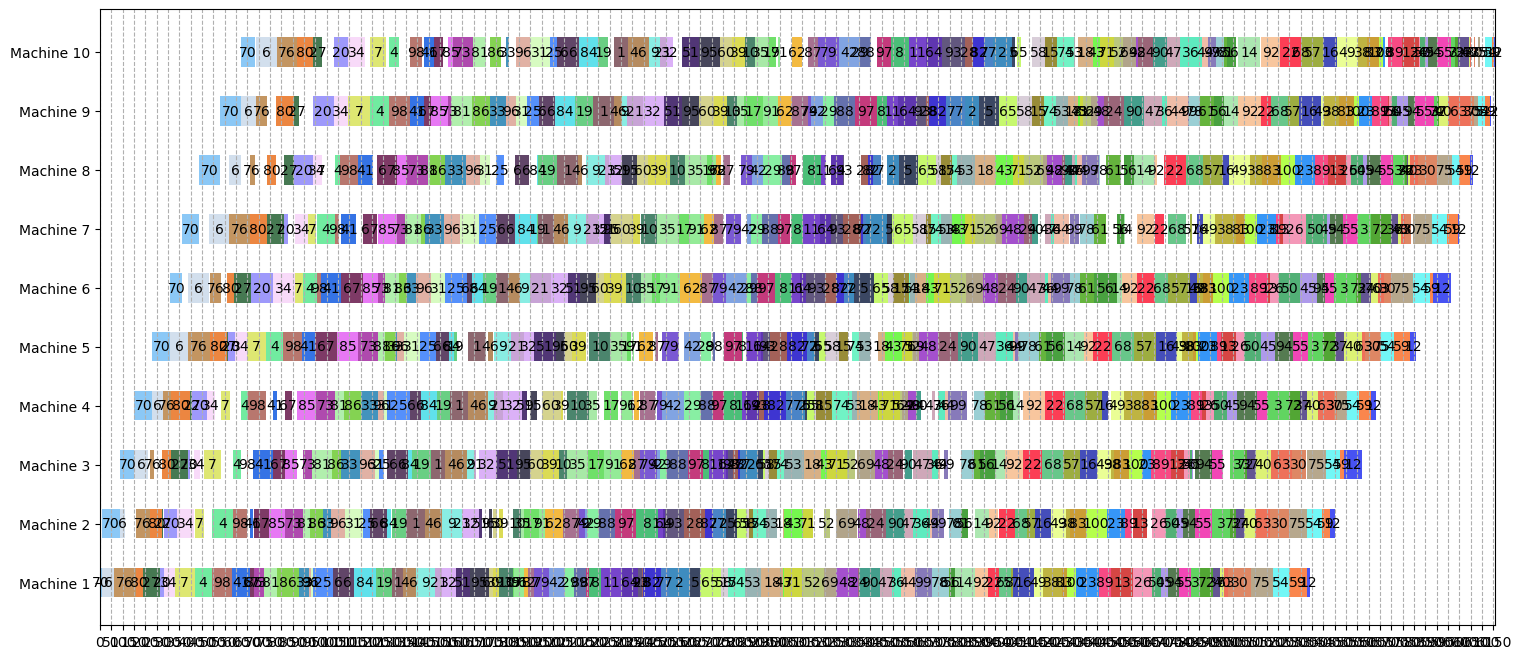

In [70]:
generate_gantt_chart(benchmark, initialSolution)    

In [71]:
print("RS With Random SWAP")
rs_solution = RS(benchmark, initialSolution, 5, method='random_swap',alpha=optimal_alpha, nb_palier=optimal_Nb_palier, it_max=optimal__it_max)

RS With Random SWAP
init_sol:  [69, 5, 75, 79, 26, 19, 33, 6, 3, 97, 40, 66, 84, 72, 80, 85, 32, 95, 30, 24, 65, 83, 18, 0, 45, 8, 20, 31, 50, 94, 59, 38, 9, 34, 16, 90, 61, 86, 78, 41, 28, 87, 96, 7, 10, 63, 92, 27, 81, 76, 1, 4, 64, 57, 14, 73, 52, 17, 42, 70, 51, 68, 47, 23, 89, 46, 35, 43, 98, 77, 60, 55, 13, 91, 21, 67, 56, 15, 48, 37, 82, 99, 22, 88, 12, 25, 49, 44, 93, 54, 2, 71, 36, 39, 62, 29, 74, 53, 58, 11]  makespan =  6062


Elapsed time: 6.987807989120483 seconds 



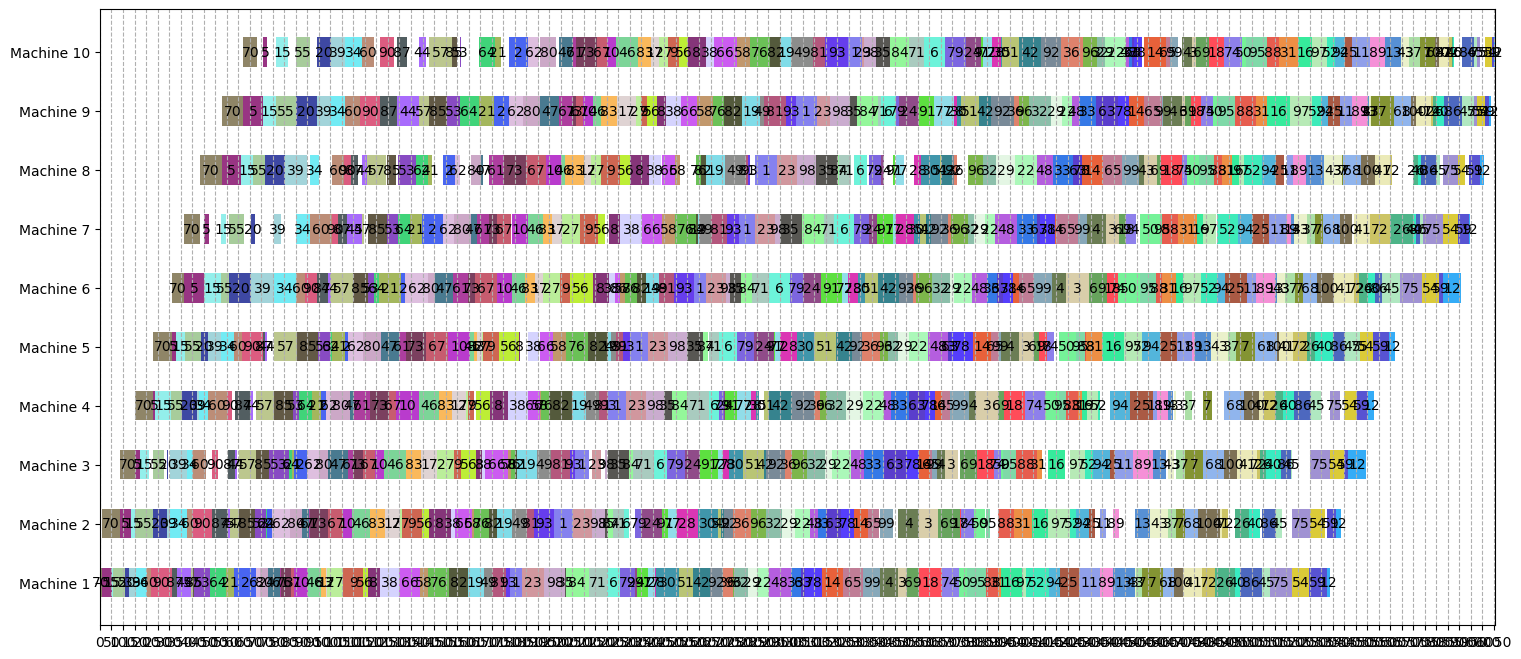

In [72]:
generate_gantt_chart(benchmark, rs_solution)    

In [73]:
print('Results of NEH:')
print(f'First sequence: {initialSolution} with a makespan of {makespan}.')
print('\nResults of RS Random swap:')
print(f'Best solution: {rs_solution} with a makespan of {calculate_makespan(benchmark, rs_solution)}.')
# print('\nResults of RS_FBA:')
# print(f'Best solution: {rs_fba_solution} with a makespan of {calculate_makespan(benchmark, rs_fba_solution)}.')
# print(f'Best global solution: {best_global_found} with a makespan of {calculate_makespan(benchmark, best_global_found)}.')

Results of NEH:
First sequence: [69, 5, 75, 79, 26, 19, 33, 6, 3, 97, 40, 66, 84, 72, 80, 85, 32, 95, 30, 24, 65, 83, 18, 0, 45, 8, 20, 31, 50, 94, 59, 38, 9, 34, 16, 90, 61, 86, 78, 41, 28, 87, 96, 7, 10, 63, 92, 27, 81, 76, 1, 4, 64, 57, 14, 73, 52, 17, 42, 70, 51, 68, 47, 23, 89, 46, 35, 43, 98, 77, 60, 55, 13, 91, 21, 67, 56, 15, 48, 37, 82, 99, 22, 88, 12, 25, 49, 44, 93, 54, 2, 71, 36, 39, 62, 29, 74, 53, 58, 11] with a makespan of 6062.

Results of RS Random swap:
Best solution: [69, 4, 14, 54, 19, 38, 33, 59, 89, 86, 43, 56, 84, 52, 63, 20, 1, 61, 79, 46, 60, 72, 66, 9, 45, 82, 16, 26, 8, 55, 7, 37, 65, 57, 75, 81, 18, 48, 80, 92, 0, 22, 97, 34, 83, 70, 5, 78, 23, 90, 76, 27, 29, 50, 41, 91, 35, 95, 31, 28, 21, 47, 32, 62, 77, 13, 64, 98, 3, 2, 68, 17, 73, 49, 94, 87, 30, 15, 96, 51, 93, 24, 10, 88, 12, 42, 36, 6, 67, 99, 40, 71, 25, 39, 85, 44, 74, 53, 58, 11] with a makespan of 5900.


### PRSKE initial solution

#### Without FBA swapping method

In [74]:
initialSolution, makespan  = PRSKE(benchmark)

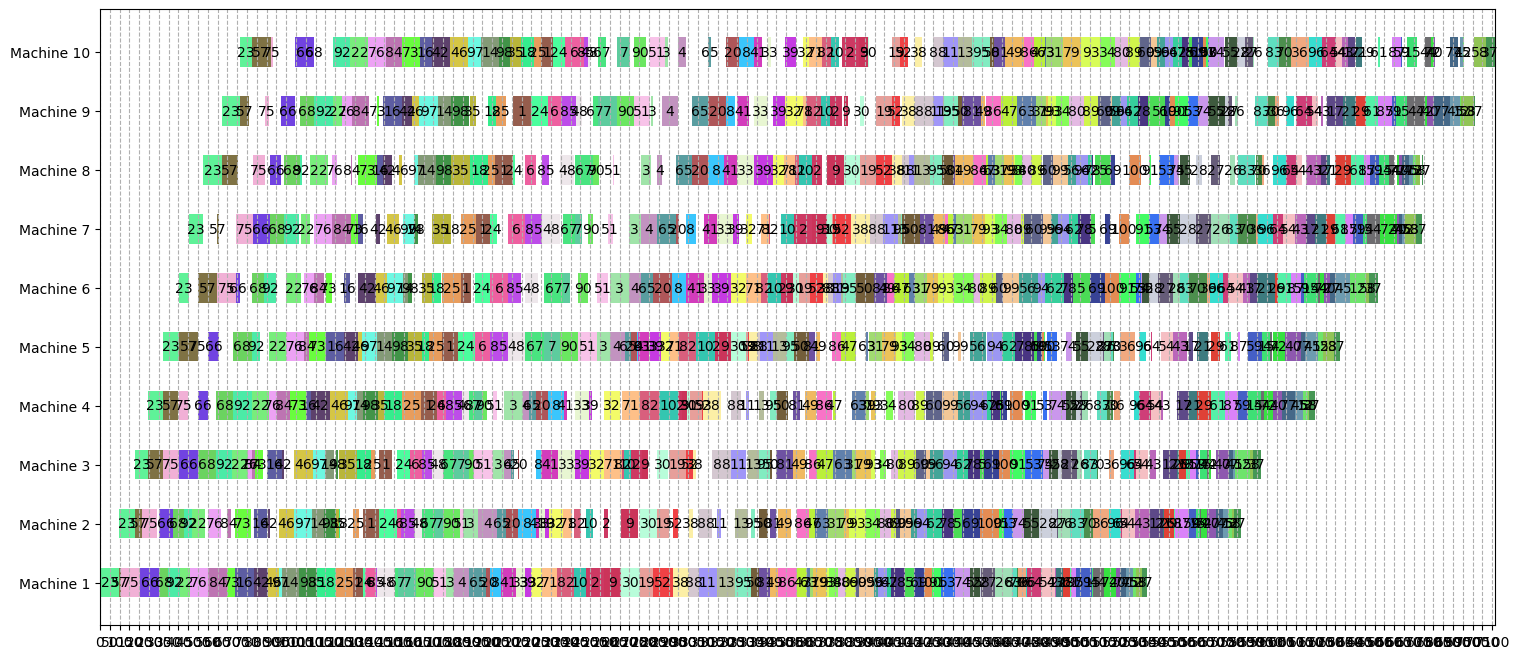

In [75]:
generate_gantt_chart(benchmark, initialSolution)

In [76]:
print("RS With Random SWAP")
rs_solution = RS(benchmark, initialSolution, 5, method='random_swap',alpha=optimal_alpha, nb_palier=optimal_Nb_palier, it_max=optimal__it_max)

RS With Random SWAP
init_sol:  [22, 56, 74, 65, 67, 91, 21, 75, 83, 72, 15, 41, 45, 96, 13, 97, 34, 17, 24, 0, 23, 5, 84, 47, 66, 6, 89, 50, 2, 3, 64, 19, 7, 40, 32, 38, 31, 70, 81, 9, 1, 8, 29, 18, 51, 37, 87, 10, 12, 94, 49, 80, 48, 85, 46, 62, 30, 78, 92, 33, 79, 88, 59, 98, 55, 93, 61, 77, 4, 68, 99, 90, 52, 73, 54, 27, 26, 25, 82, 69, 35, 95, 63, 53, 42, 16, 20, 28, 60, 86, 58, 14, 43, 71, 39, 76, 44, 11, 57, 36]  makespan =  7093


Elapsed time: 5.805347681045532 seconds 



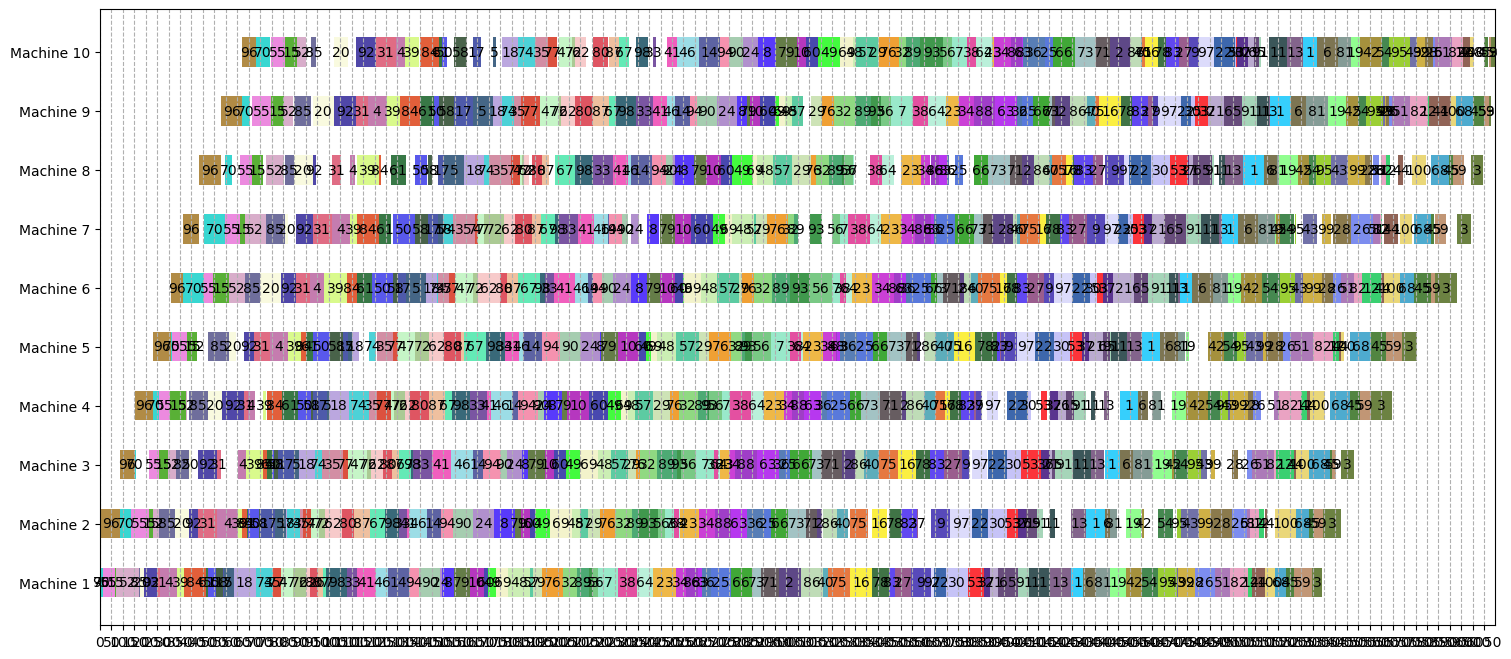

In [77]:
generate_gantt_chart(benchmark, rs_solution)

In [78]:
print('Results of PRSKE:')
print(f'First sequence: {initialSolution} with a makespan of {makespan}.')
print('\nResults of RS:')
print(f'Best solution: {rs_solution} with a makespan of {calculate_makespan(benchmark, rs_solution)}')
# print('\nResults of RS_FBA:')
# print(f'Best solution: {rs_fba_solution} with a makespan of {calculate_makespan(benchmark, rs_fba_solution)}.')
# print(f'Best global solution: {best_global_found} with a makespan of {calculate_makespan(benchmark, best_global_found)}.')

Results of PRSKE:
First sequence: [22, 56, 74, 65, 67, 91, 21, 75, 83, 72, 15, 41, 45, 96, 13, 97, 34, 17, 24, 0, 23, 5, 84, 47, 66, 6, 89, 50, 2, 3, 64, 19, 7, 40, 32, 38, 31, 70, 81, 9, 1, 8, 29, 18, 51, 37, 87, 10, 12, 94, 49, 80, 48, 85, 46, 62, 30, 78, 92, 33, 79, 88, 59, 98, 55, 93, 61, 77, 4, 68, 99, 90, 52, 73, 54, 27, 26, 25, 82, 69, 35, 95, 63, 53, 42, 16, 20, 28, 60, 86, 58, 14, 43, 71, 39, 76, 44, 11, 57, 36] with a makespan of 7093.

Results of RS:
Best solution: [95, 69, 54, 14, 51, 84, 19, 91, 30, 3, 38, 83, 60, 49, 57, 16, 4, 17, 73, 34, 76, 46, 71, 61, 79, 86, 66, 97, 32, 40, 45, 13, 93, 89, 23, 7, 78, 9, 59, 48, 68, 47, 56, 28, 75, 31, 88, 92, 55, 6, 37, 63, 22, 33, 87, 62, 35, 24, 65, 72, 70, 1, 85, 39, 74, 15, 77, 82, 26, 8, 96, 21, 29, 52, 36, 20, 64, 90, 10, 12, 0, 5, 80, 18, 41, 53, 94, 42, 98, 27, 25, 50, 81, 11, 43, 99, 67, 44, 58, 2] with a makespan of 6009


## VNS Test

####  Taillard, 20 jobs & 5 machines

In [79]:
nb_jobs = 20
nb_machines = 5

In [80]:
benchmarks = read_flow_shop_data(f'./utils/benchmarks/{nb_jobs}_{nb_machines}.txt', nb_machines, nb_jobs)
benchmark = benchmarks[0][2].T
benchmark

array([[54, 79, 16, 66, 58],
       [83,  3, 89, 58, 56],
       [15, 11, 49, 31, 20],
       [71, 99, 15, 68, 85],
       [77, 56, 89, 78, 53],
       [36, 70, 45, 91, 35],
       [53, 99, 60, 13, 53],
       [38, 60, 23, 59, 41],
       [27,  5, 57, 49, 69],
       [87, 56, 64, 85, 13],
       [76,  3,  7, 85, 86],
       [91, 61,  1,  9, 72],
       [14, 73, 63, 39,  8],
       [29, 75, 41, 41, 49],
       [12, 47, 63, 56, 47],
       [77, 14, 47, 40, 87],
       [32, 21, 26, 54, 58],
       [87, 86, 75, 77, 18],
       [68,  5, 77, 51, 68],
       [94, 77, 40, 31, 28]])

##### NEH initial solution

In [81]:
initialSolution, makespan = neh_algorithm(benchmark)
print('Results of NEH:')
print(f'First sequence: {initialSolution} with a makespan of {makespan}.')

Results of NEH:
First sequence: [8, 6, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 9, 11, 0, 18, 5, 4, 12, 19] with a makespan of 1334.


In [82]:
start_time = time.time()
sol, Cmax = vns(initialSolution, benchmark, 100, 5)
elapsed_time = time.time() - start_time

print(f'\n\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")



Generated Solution: [8, 12, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 9, 11, 0, 18, 5, 4, 6, 19].
Makespan: 1331

Elapsed time:  0.10235095024108887 seconds


####  Taillard, 50 jobs & 10 machines

In [83]:
nb_jobs = 50
nb_machines = 10

In [84]:
benchmarks = read_flow_shop_data(f'./utils/benchmarks/{nb_jobs}_{nb_machines}.txt', nb_machines, nb_jobs)
benchmark = benchmarks[0][2].T
benchmark

array([[46, 61,  3, 51, 37, 79, 83, 22, 27, 24],
       [52, 87,  1, 24, 16, 93, 87, 29, 92, 47],
       [79, 51, 58, 21, 42, 68, 38, 99, 75, 39],
       [45, 25, 85, 57, 47, 75, 38, 25, 94, 66],
       [97, 73, 33, 69, 94, 37, 86, 98, 18, 41],
       [10, 93, 71, 51, 14, 44, 67, 55, 41, 46],
       [44, 28, 58, 50, 94, 34, 23, 80, 37, 24],
       [24, 90, 56, 51, 34, 39, 19, 82, 58, 23],
       [85, 94, 64, 21, 72, 76, 97, 33, 56, 68],
       [75, 59, 43, 19, 36, 62, 78, 68, 20, 50],
       [66, 64, 48, 63, 88, 74, 66, 47,  2, 93],
       [49,  2, 69, 91, 51, 28, 67, 74, 39, 22],
       [95, 16, 96, 11, 41, 78,  7, 26, 91, 64],
       [61, 35, 35,  6, 71, 43, 23, 61, 81, 81],
       [19, 53, 82, 31, 94, 98, 67, 95, 33, 94],
       [47, 40, 53, 63, 99, 83,  8, 55, 14, 97],
       [84, 81, 64, 36, 11, 91, 77, 11, 88, 54],
       [13, 26, 11, 39, 97, 27, 71, 42, 22, 82],
       [11, 85, 61, 57, 44,  6, 85, 72, 36, 11],
       [19,  4, 36, 47, 77, 82, 29, 14, 65, 91],
       [98,  4, 53, 

##### NEH initial solution

In [85]:
initialSolution, makespan = neh_algorithm(benchmark)
print('Results of NEH:')
print(f'First sequence: {initialSolution} with a makespan of {makespan}.')

Results of NEH:
First sequence: [19, 33, 30, 14, 35, 13, 41, 34, 9, 43, 32, 42, 24, 11, 39, 46, 17, 47, 12, 40, 37, 8, 4, 45, 28, 1, 2, 10, 44, 21, 5, 3, 48, 16, 31, 29, 25, 49, 23, 0, 15, 36, 7, 27, 6, 22, 20, 38, 26, 18] with a makespan of 3229.


In [86]:
start_time = time.time()
sol, Cmax = vns(initialSolution, benchmark, 100, 5)
elapsed_time = time.time() - start_time

print(f'\n\nGenerated Solution: {sol}.')
print(f'Makespan: {Cmax}')
print("\nElapsed time: ", elapsed_time, "seconds")



Generated Solution: [19, 33, 30, 14, 35, 13, 41, 34, 9, 43, 32, 42, 24, 48, 6, 0, 17, 39, 12, 40, 37, 8, 4, 45, 3, 1, 2, 10, 44, 21, 5, 28, 11, 16, 31, 29, 25, 46, 23, 49, 15, 36, 7, 27, 26, 22, 20, 38, 47, 18].
Makespan: 3190

Elapsed time:  0.8062841892242432 seconds
